# Nonsolobaschet Stats | 2018

In [1]:
import fanta
import config

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scores txt files

### Gianluca | La mamma di Enrico

In [2]:
%%writefile gianluca.txt
gg pf ps gs c mdif
1 82 77.5 1 1 1
2 63.5 67 1 3 0
3 68.5 79 1 1 0
4 67.5 79.5 0 3 1
5 79.5 76.5 0 2 3
6 69.5 77 1 1 1
7 75 65 0 1 1
8 71.5 69.5 1 1 0
9 74.5 80 0 2 1
10 70.5 82.5 1 1 1
11 60 69 2 1 0
12 64 65 1 1 1
13 69.5 71.5 2 3 1
14 77.5 86 1 3 1
15 72 75 0 1 0
16 62 68.5 1 2 0
17 66.5 72 1 1 1
18 62.5 74 0 0 0
19 80 87.5 2 2 0
20 69 68 3 4 0
21 75.5 66.5 0 2 3
22 69.5 76.5 1 2 1
23 73.5 81 1 0 1
24 68.5 76 0 1 1
25 72 71 1 0 1
26 74 76 2 1 1

Overwriting gianluca.txt


### Fabio | Porti Chiusi Italiani

In [3]:
%%writefile fabio.txt
gg pf ps gs c mdif
1 77 72 3 3 0
2 67.5 57.5 1 2 0
3 79 68.5 4 2 0
4 73.5 65.5 0 1 0
5 69.5 78.5 2 2 0
6 77 68 1 3 0
7 65 70 1 3 0
8 69.5 71.5 0 0 0
9 64.5 70.5 0 1 0
10 82 62 1 2 0
11 68 82 4 1 0
12 65 75.5 1 3 1
13 71.5 69.5 0 2 0
14 87.5 72 1 2 0
15 82 68.5 0 2 0
16 71.5 79.5 1 1 0
17 76.5 86 1 4 0
18 74 62.5 2 4 1
19 80.5 68.5 0 1 3
20 79 65 2 2 1
21 78.5 75 0 1 0
22 76 77 1 1 1
23 81 73.5 0 1 0
24 78.5 72 0 1 0
25 81.5 74 0 0 1
26 64.5 80 1 3 0

Overwriting fabio.txt


### Enrico | Gianlucanonpressare

In [4]:
%%writefile enrico.txt
gg pf ps gs c mdif
1 79.5 61 1 2 3
2 57.5 67.5 2 4 0
3 76 78 0 3 1
4 79.5 67.5 1 1 1
5 76 78.5 1 2 1
6 72.5 71 0 2 1
7 70 65 1 3 1
8 73 74.5 2 4 1
9 80 74.5 0 2 1
10 82 76 2 2 3
11 83 66.5 0 3 0
12 75.5 65 2 2 3
13 69.5 76.5 0 1 1
14 86 77.5 1 0 3
15 84.5 79.5 0 3 6
16 78.5 68.5 0 1 3
17 86 76.5 2 1 1
18 74 69.5 0 2 3
19 87.5 80 1 2 1
20 60 68.5 1 4 0
21 72 65 0 3 3
22 77 76 0 2 3
23 81.5 73 0 1 1
24 76 68.5 1 2 1
25 79.5 75 3 0 1
26 81.5 70.5 2 2 3

Overwriting enrico.txt


### Gabriele | Sciagura

In [5]:
%%writefile gabriele.txt
gg pf ps gs c mdif
1 72 77 0 1 1
2 72 74.5 0 3 3
3 78 76 1 2 1
4 67 77.5 2 2 0
5 76.5 79.5 3 2 0
6 68 77 2 3 1
7 74.5 73.5 1 6 1
8 74.5 73 1 3 0
9 73 71 1 3 1
10 82.5 70.5 0 2 1
11 82 68 1 1 1
12 71.5 73 0 2 1
13 76.5 69.5 1 4 3
14 69 61 0 2 1
15 75 72 1 0 1
16 79.5 71.5 1 2 1
17 68.5 69.5 1 2 1
18 69.5 74 1 4 0
19 67 69 0 5 0
20 68 69 2 4 0
21 75 78.5 2 2 1
22 81 73 1 4 1
23 73 81.5 2 0 1
24 70 85.5 3 4 1
25 71 72 1 3 0
26 80 64.5 0 2 1

Overwriting gabriele.txt


### Luca | Nottingham Forrest Gump

In [6]:
%%writefile luca.txt
gg pf ps gs c mdif
1 77.5 82 0 1 3
2 74.5 72 2 1 1
3 80.5 77 0 0 1
4 65.5 73.5 2 1 1
5 78.5 76 0 3 1
6 77 69.5 1 1 1
7 73.5 74.5 0 0 1
8 76.5 66 1 2 1
9 70.5 64.5 2 3 1
10 76 82 0 2 1
11 69 60 0 2 1
12 73 71.5 1 5 3
13 65.5 61 1 2 1
14 72 87.5 0 3 1
15 79.5 84.5 1 4 1
16 68.5 62 0 2 1
17 69.5 68.5 1 1 1
18 61 67 1 5 1
19 68.5 80.5 1 1 0
20 68.5 60 1 4 1
21 66.5 75.5 1 1 1
22 73 81 2 2 1
23 79 80.5 0 2 1
24 72 78.5 3 0 1
25 75 79.5 1 1 0
26 76 74 1 0 1

Overwriting luca.txt


### Ale | Sanfa

In [7]:
%%writefile ale.txt
gg pf ps gs c mdif
1 61 79.5 2 1 0
2 67 63.5 1 0 0
3 77 80.5 3 4 0
4 77.5 67 1 2 3
5 78.5 69.5 1 0 0
6 71 72.5 1 1 0
7 65 75 4 5 0
8 66 76.5 2 1 0
9 71 73 0 2 1
10 62 82 3 4 0
11 66.5 83 0 1 0
12 65 64 2 2 0
13 61 65.5 3 2 0
14 61 69 2 1 1
15 68.5 82 0 2 0
16 68.5 78.5 0 3 0
17 72 66.5 2 1 1
18 67 61 7 3 0
19 69 67 2 2 0
20 65 79 3 2 0
21 65 72 1 2 1
22 76.5 69.5 1 2 3
23 80.5 79 2 1 1
24 85.5 70 0 0 1
25 74 81.5 2 0 0
26 79.5 81.5 2 0 1

Overwriting ale.txt


# Fill dataframe

In [8]:
df_final = fanta.configure_db()

### Global variables and stats #############################
games = max(df_final.index)   # Total number of matchdays, including uncompleted ones
games_completed = len(df_final.index.unique())   # Total number of matchdays completed
fp_mean = np.mean(df_final['fantapoints made'])
fp_med = np.median(df_final['fantapoints made'])
fp_std = np.std(df_final['fantapoints made'])
gm_mean = np.mean(df_final['GM'])
gm_med = np.median(df_final['GM'])
gm_std = np.std(df_final['GM'])

df_total = fanta.total_df(df_final)

In [9]:
### Data of the last matchday
print('\n### Data matchday number', games, ' ###')
df_last_day = df_final[df_final.index==games]
df_last_day.set_index('team', inplace=True)
display(df_last_day)

### Cumulative data
print('\n\n### Cumulative data after matchday', games, '(', games_completed,' completed )  ###')
param=['pos', 'points', 'distance', 'fantapoints made', 'rank', 'fantapoints against',
       'results', 'GM', 'GA', 'goals against gk',
      'cards', 'defense modifier', 'f_close_games', 'f_day_average', 'Luck Index'
      ] # Parameters to display
display(df_total[param].sort_values(by=['points', 'fantapoints made'], ascending=False))


### Data matchday number 26  ###


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
team,,,,,,,,,,,,
ale,79.5,81.5,2,0,1,3,4,L,0,-0.6,-1.6,-2.2
enrico,81.5,70.5,2,2,3,4,1,W,3,0.0,0.0,0.0
fabio,64.5,80.0,1,3,0,0,3,L,0,0.0,0.0,0.0
gabriele,80.0,64.5,0,2,1,3,0,W,3,0.0,1.4,1.4
gianluca,74.0,76.0,2,1,1,2,3,L,0,-0.6,-0.6,-1.2
luca,76.0,74.0,1,0,1,3,2,W,3,1.2,1.4,2.6




### Cumulative data after matchday 26 ( 26  completed )  ###


,pos,points,distance,fantapoints made,rank,fantapoints against,results,GM,GA,goals against gk,cards,defense modifier,f_close_games,f_day_average,Luck Index
team,,,,,,,,,,,,,,,
enrico,1,59,0,1998.0,1,1869.5,"18W,5T,3L",74,46,23,54,46,0.6,6.4,7.0
fabio,2,49,10,1940.0,2,1864.5,"16W,1T,9L",61,44,27,48,8,1.4,3.8,5.2
gabriele,3,33,26,1914.5,3,1901.0,"7W,12T,7L",55,52,28,68,23,-1.8,-4.0,-5.8
luca,4,29,30,1886.5,4,1908.5,"7W,8T,11L",48,55,23,49,28,-4.7,-3.0,-7.7
ale,5,28,31,1820.5,6,1908.0,"7W,7T,12L",37,53,47,44,13,0.5,3.6,4.1
gianluca,6,17,42,1838.0,5,1937.0,"4W,5T,17L",38,61,24,40,21,-1.3,-6.4,-7.7


# Luck Index

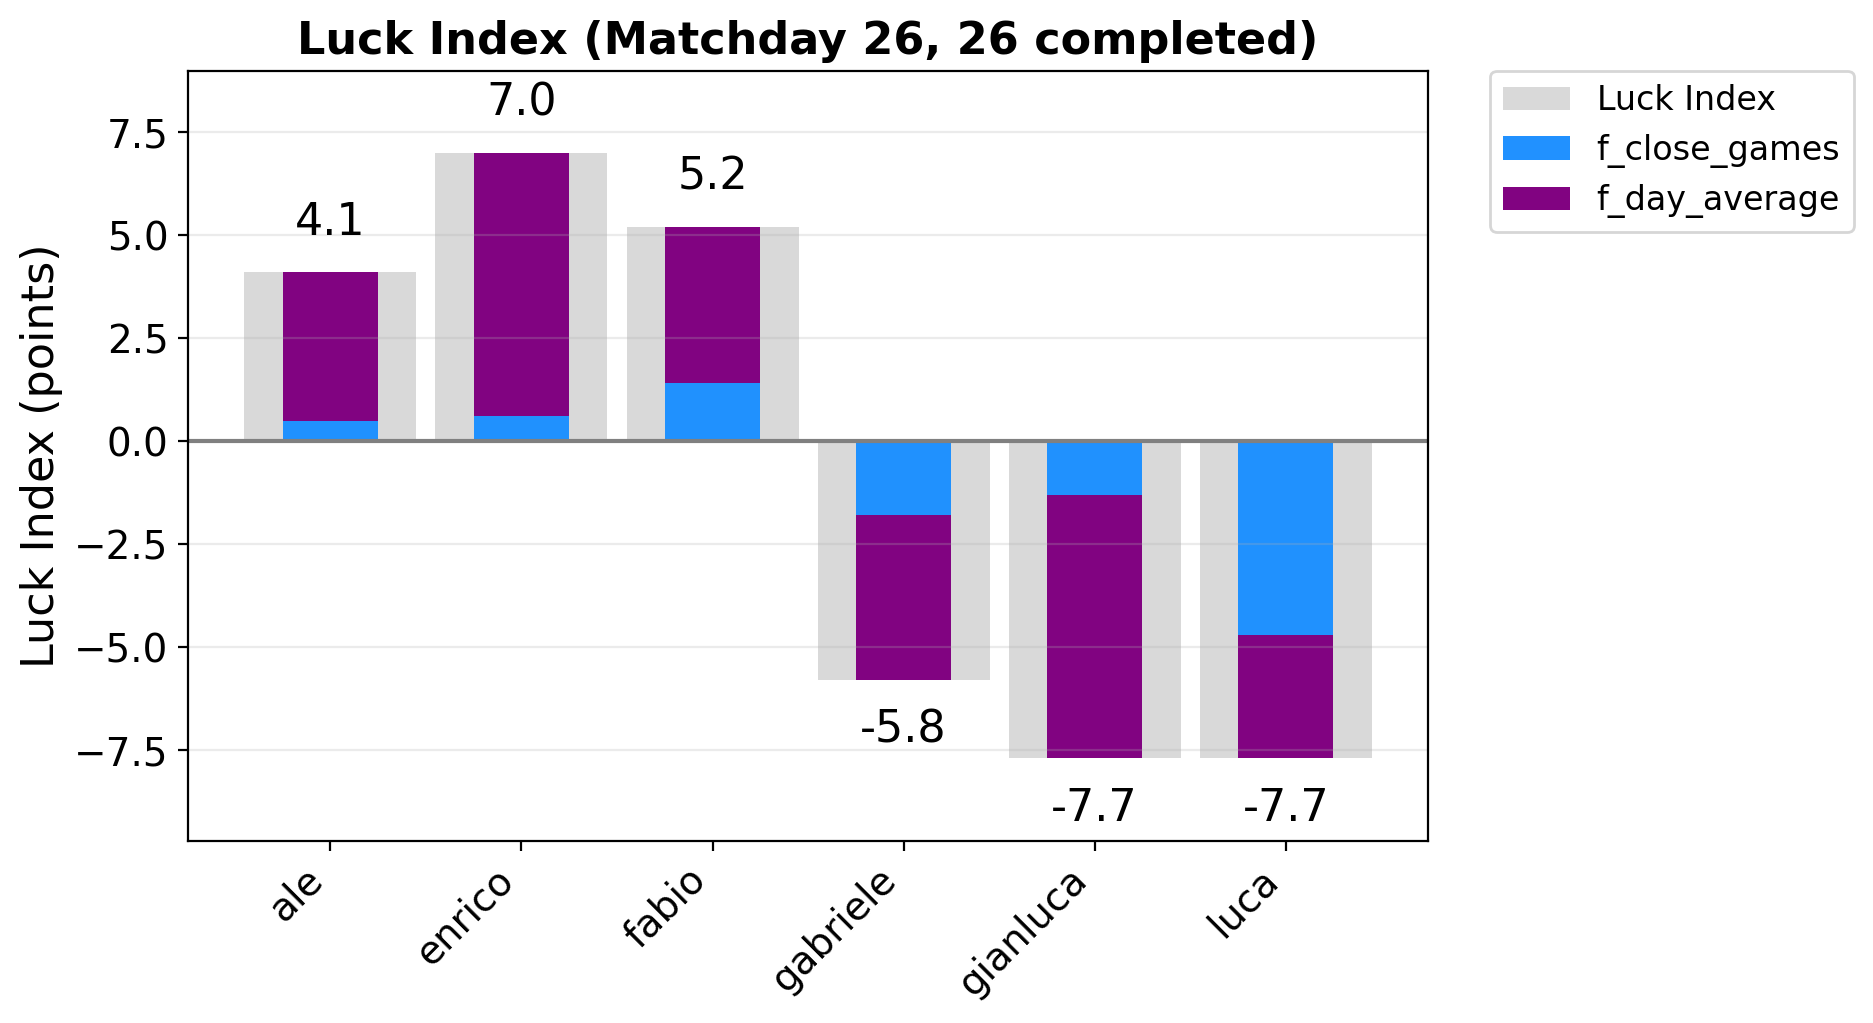

In [10]:
fanta.luck_index_plot(df_total, games, games_completed)

# Evolution Plots

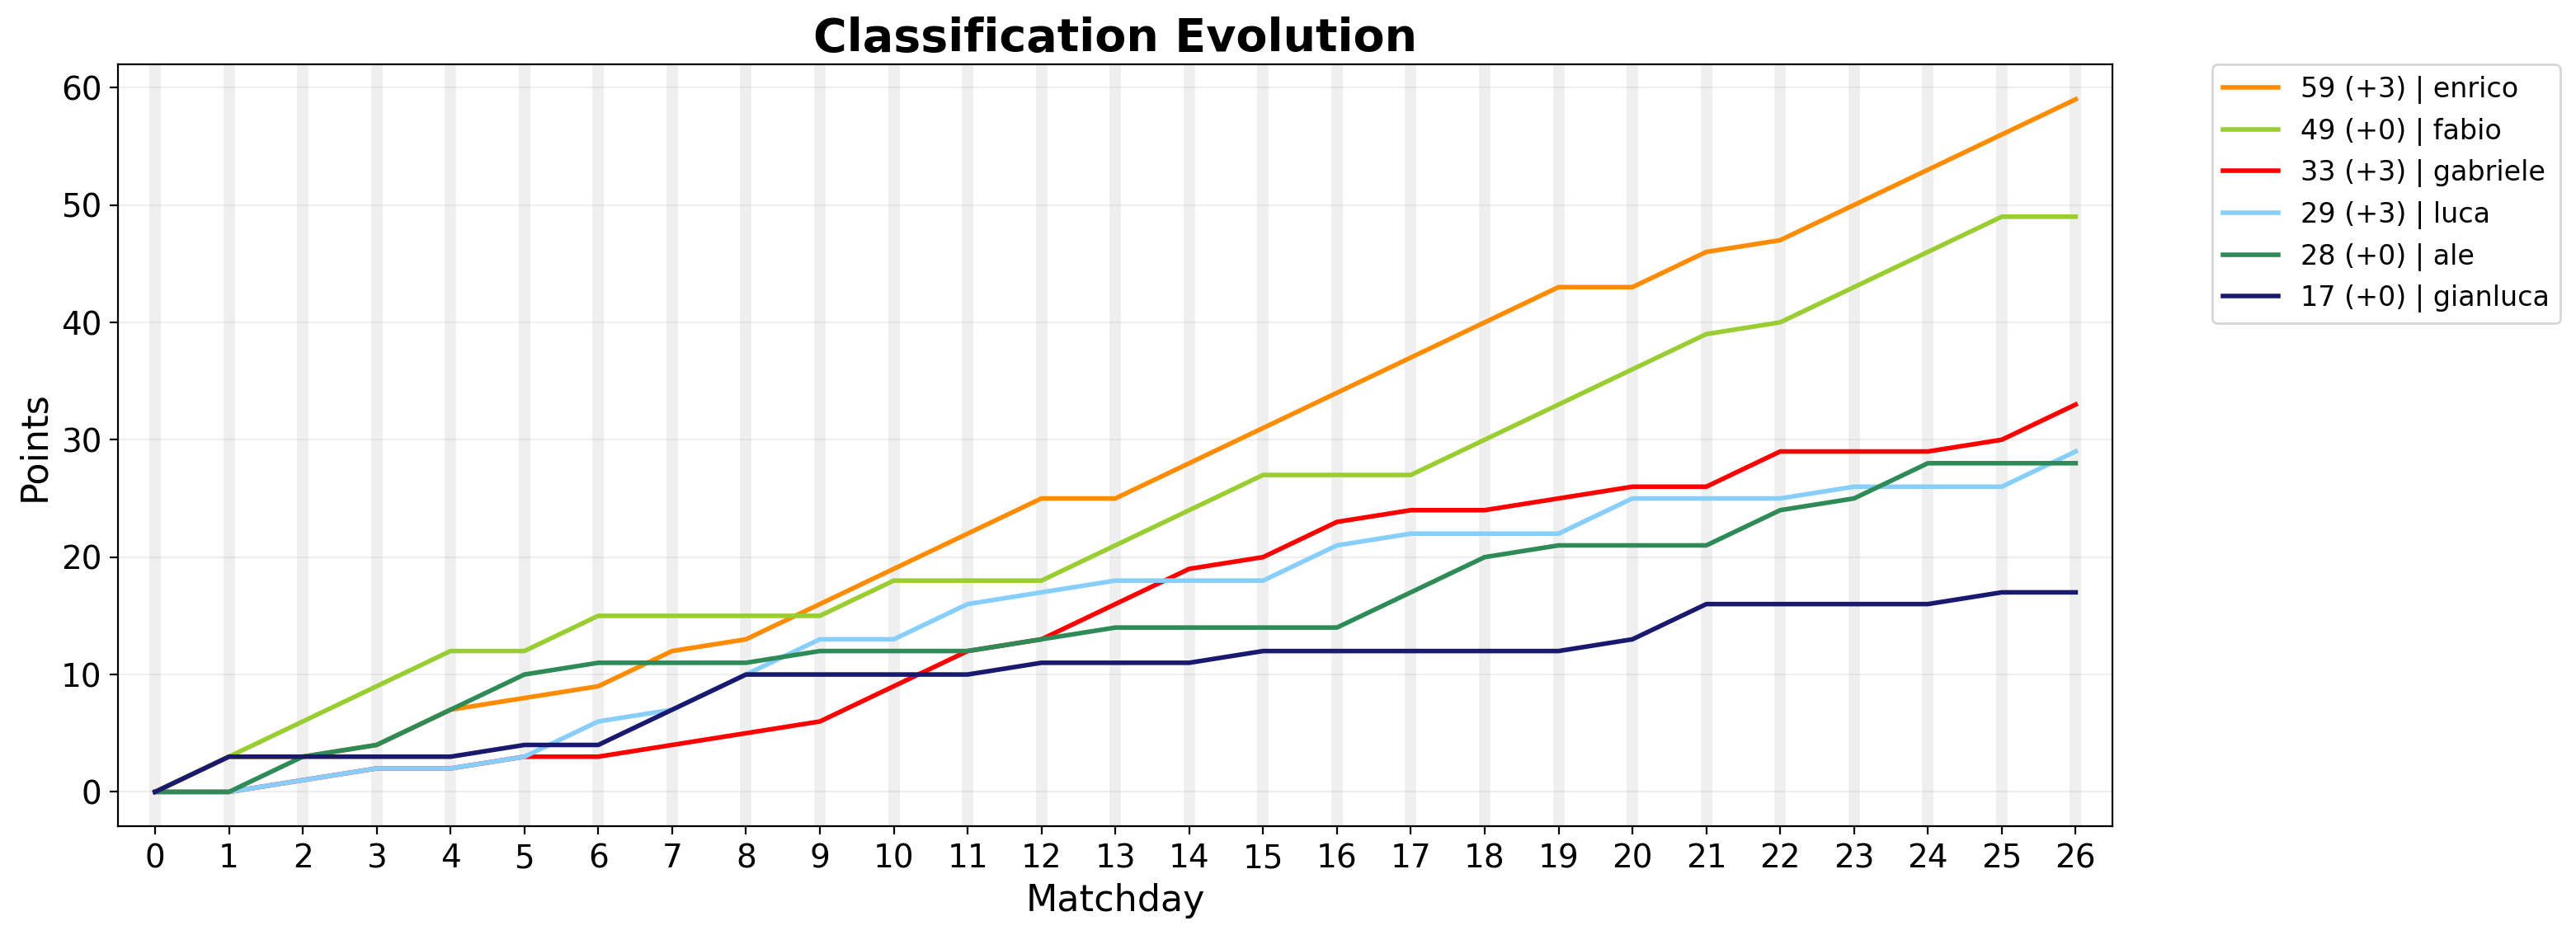

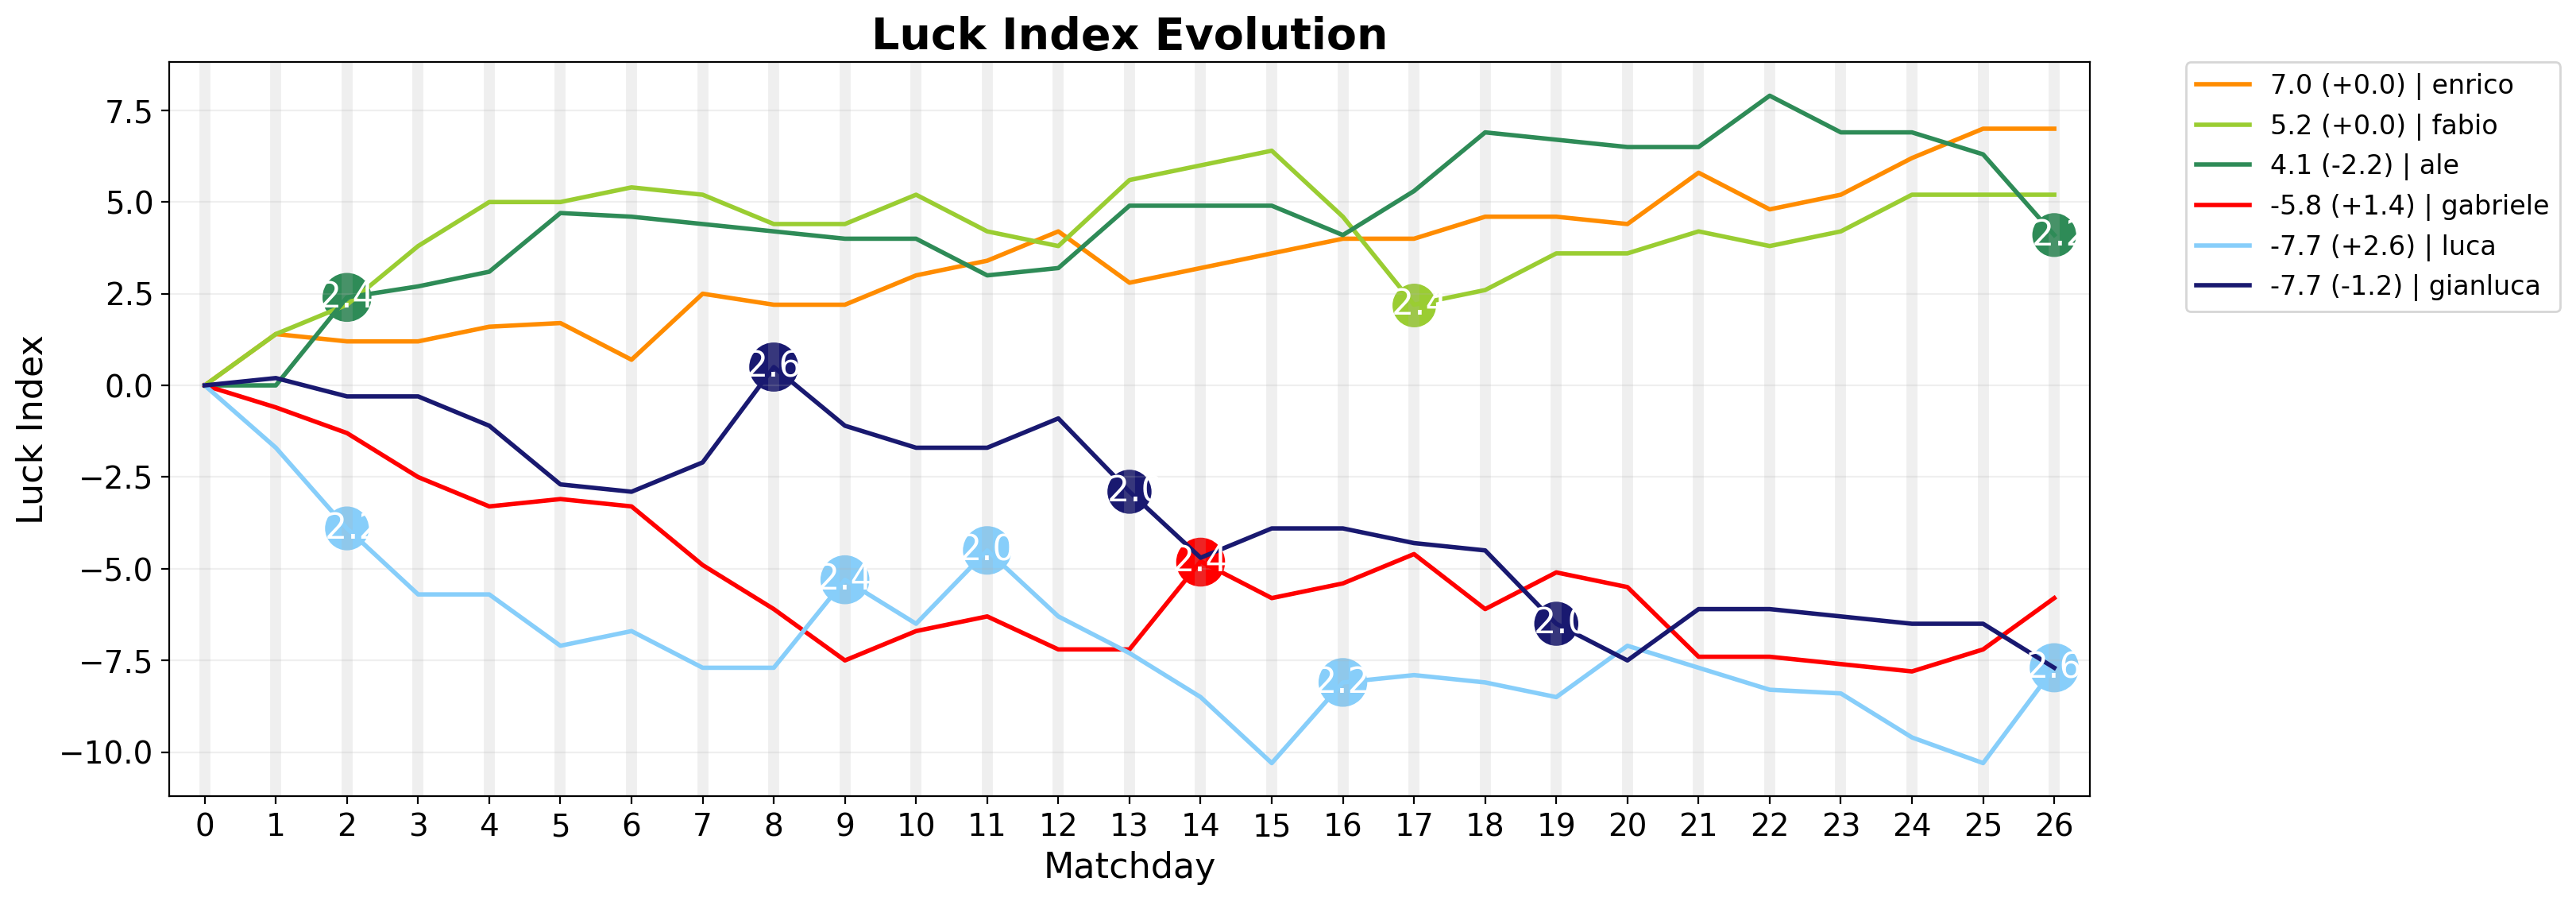

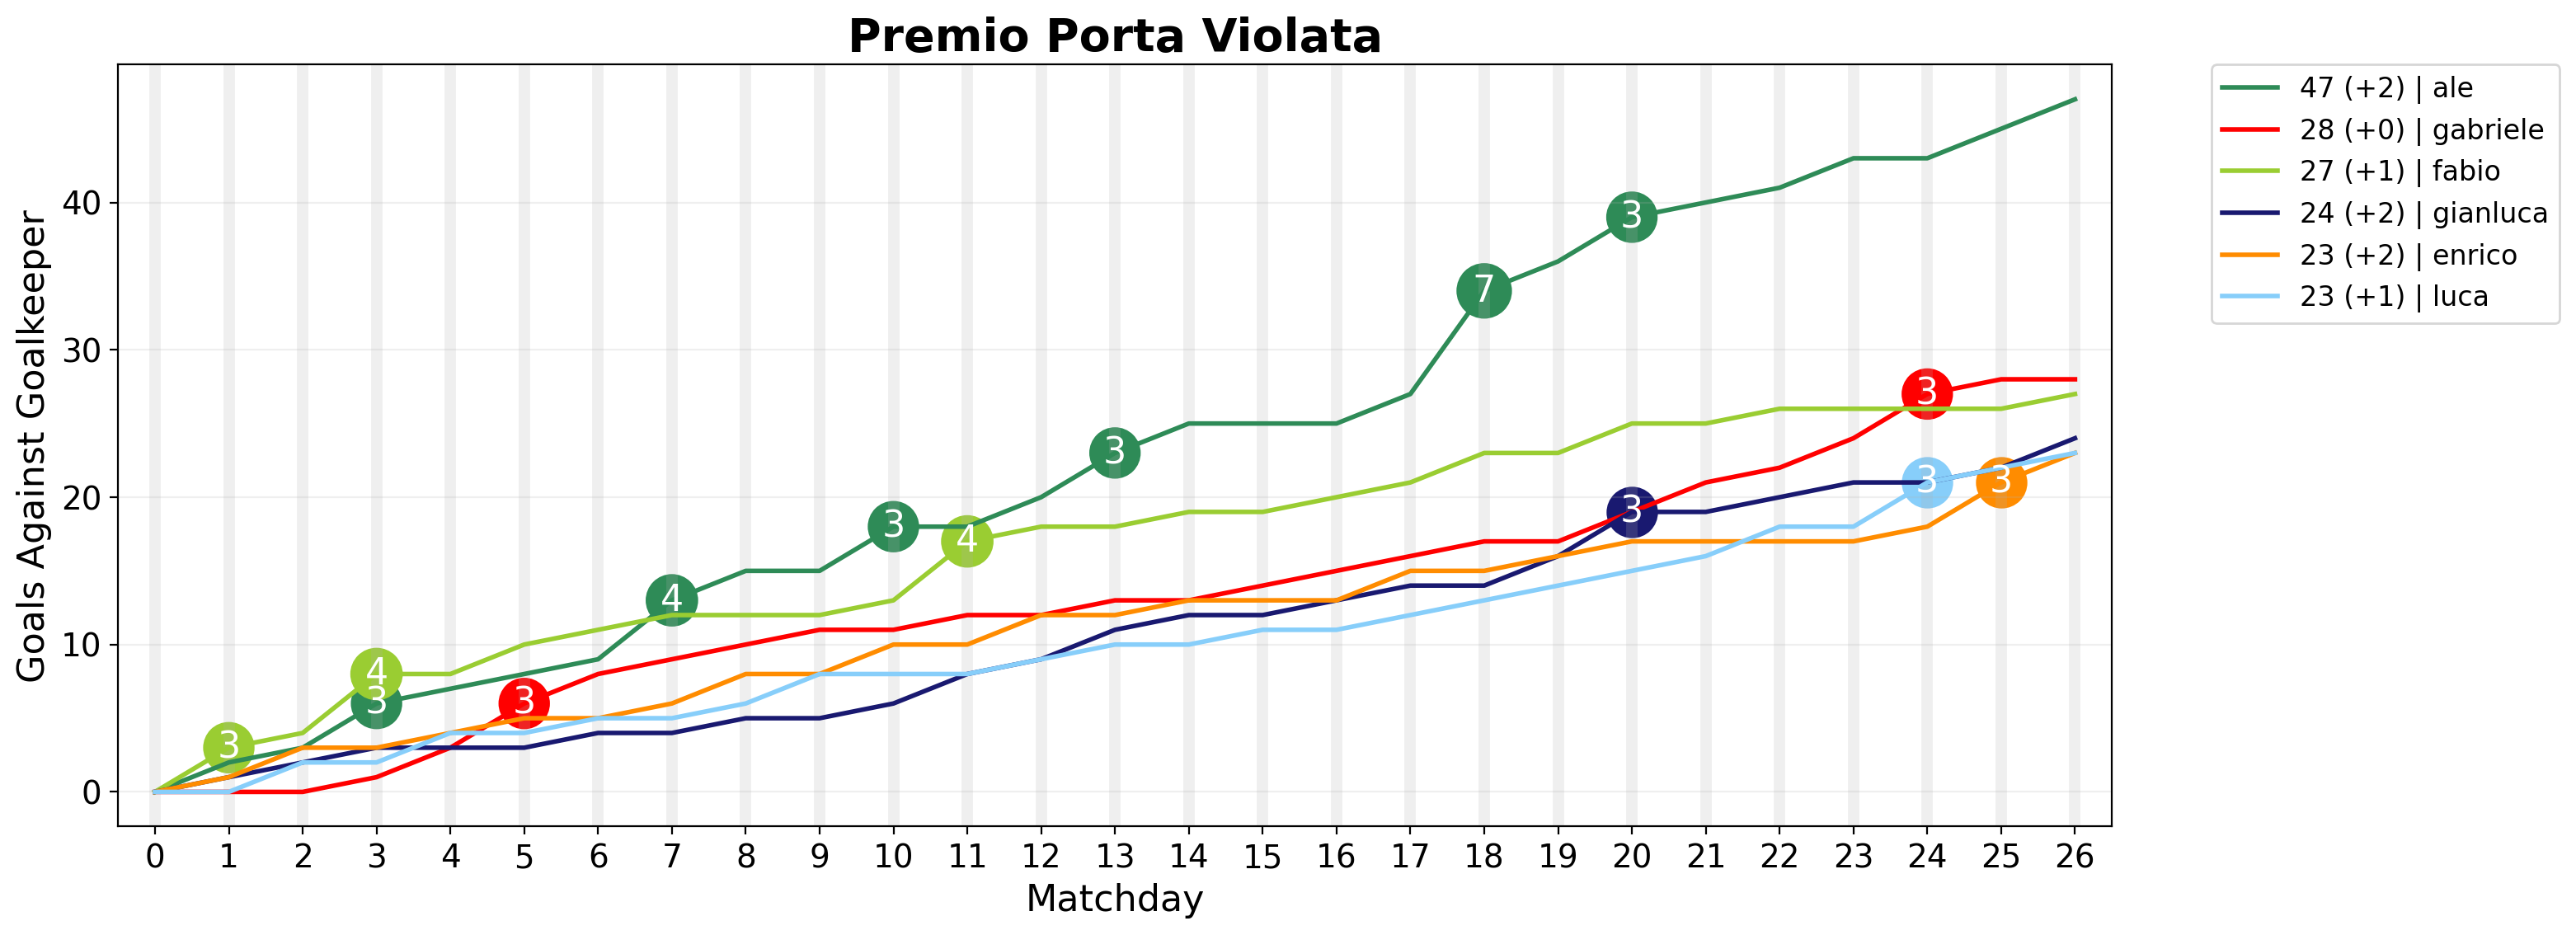

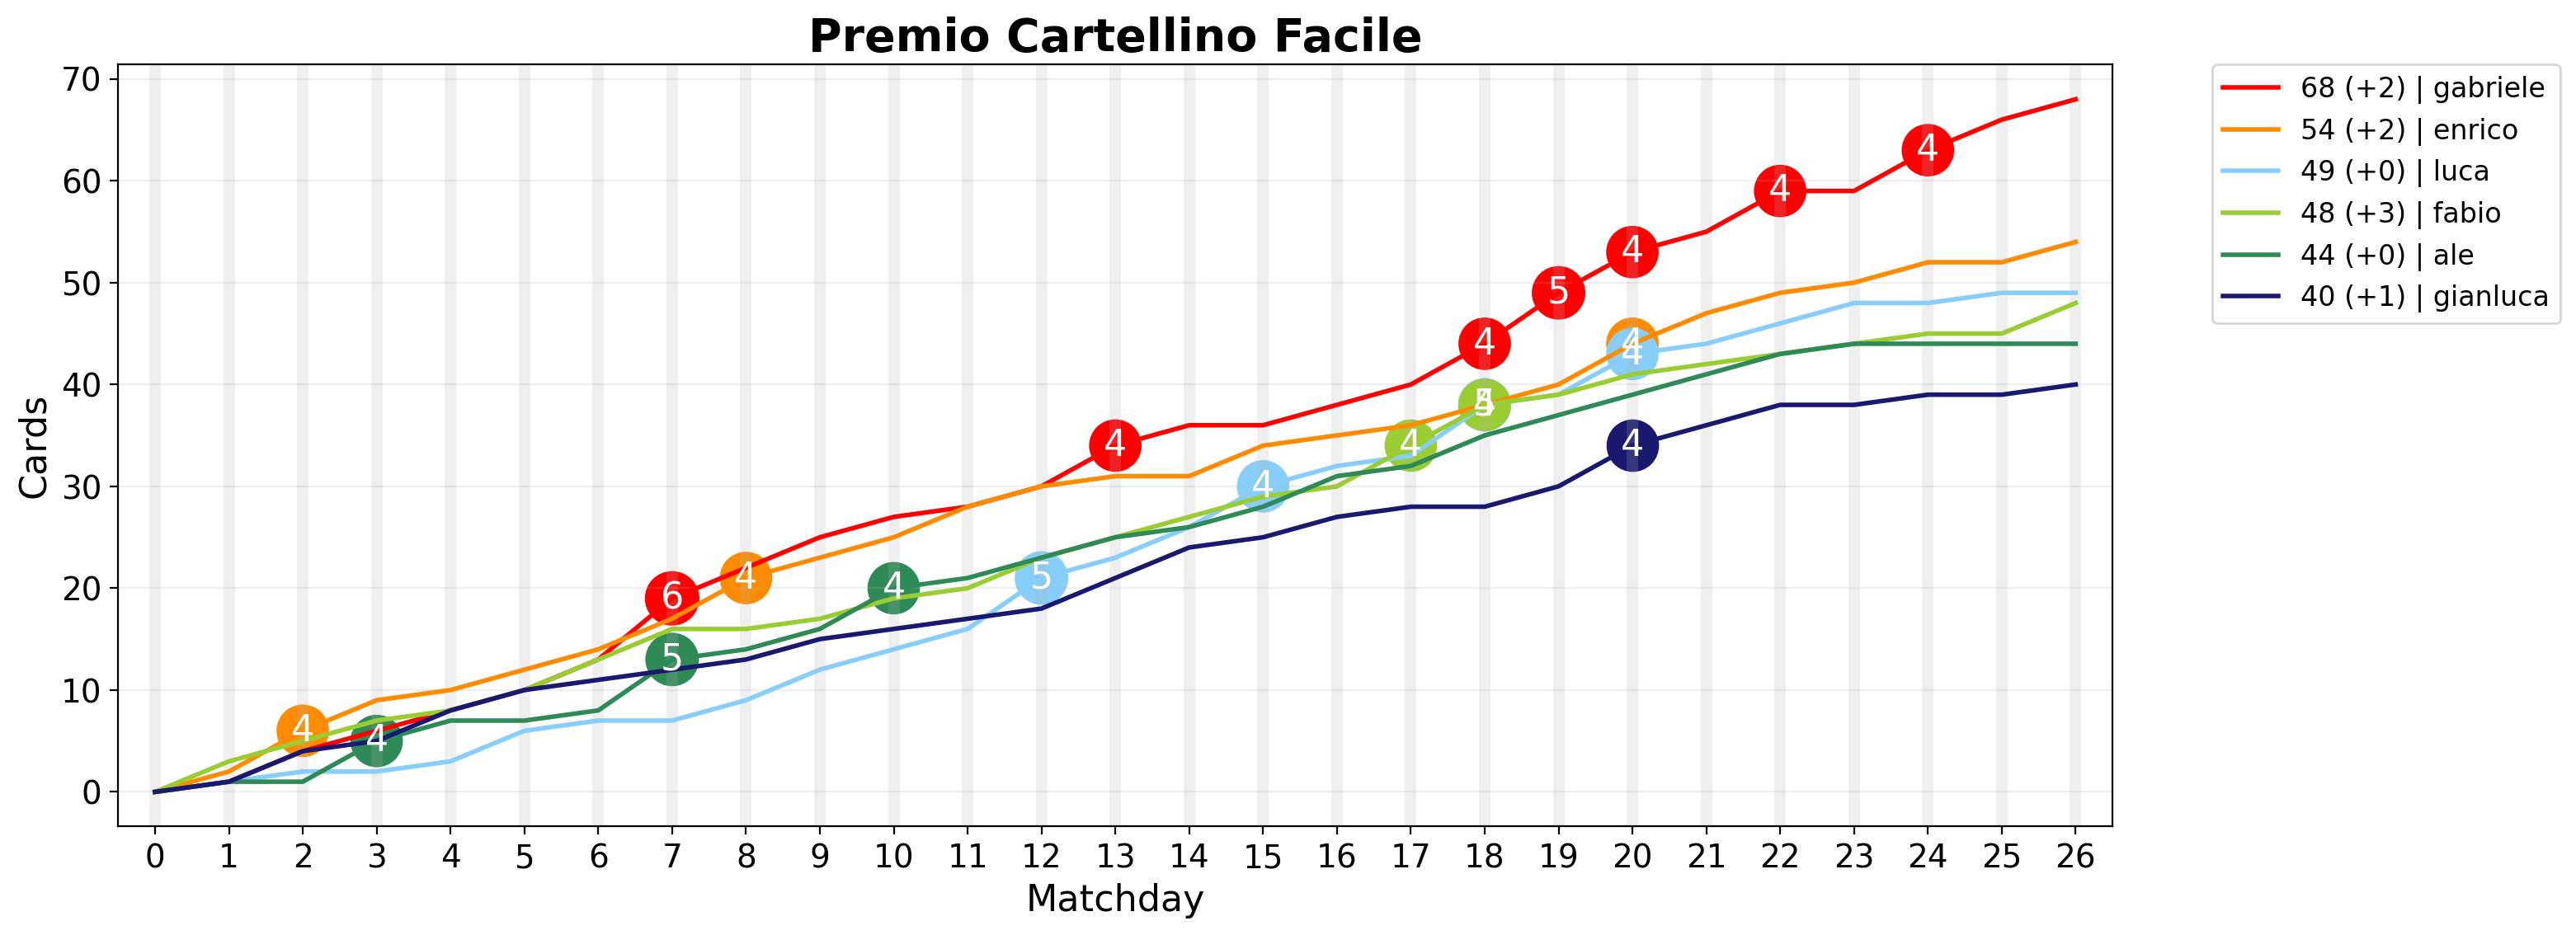

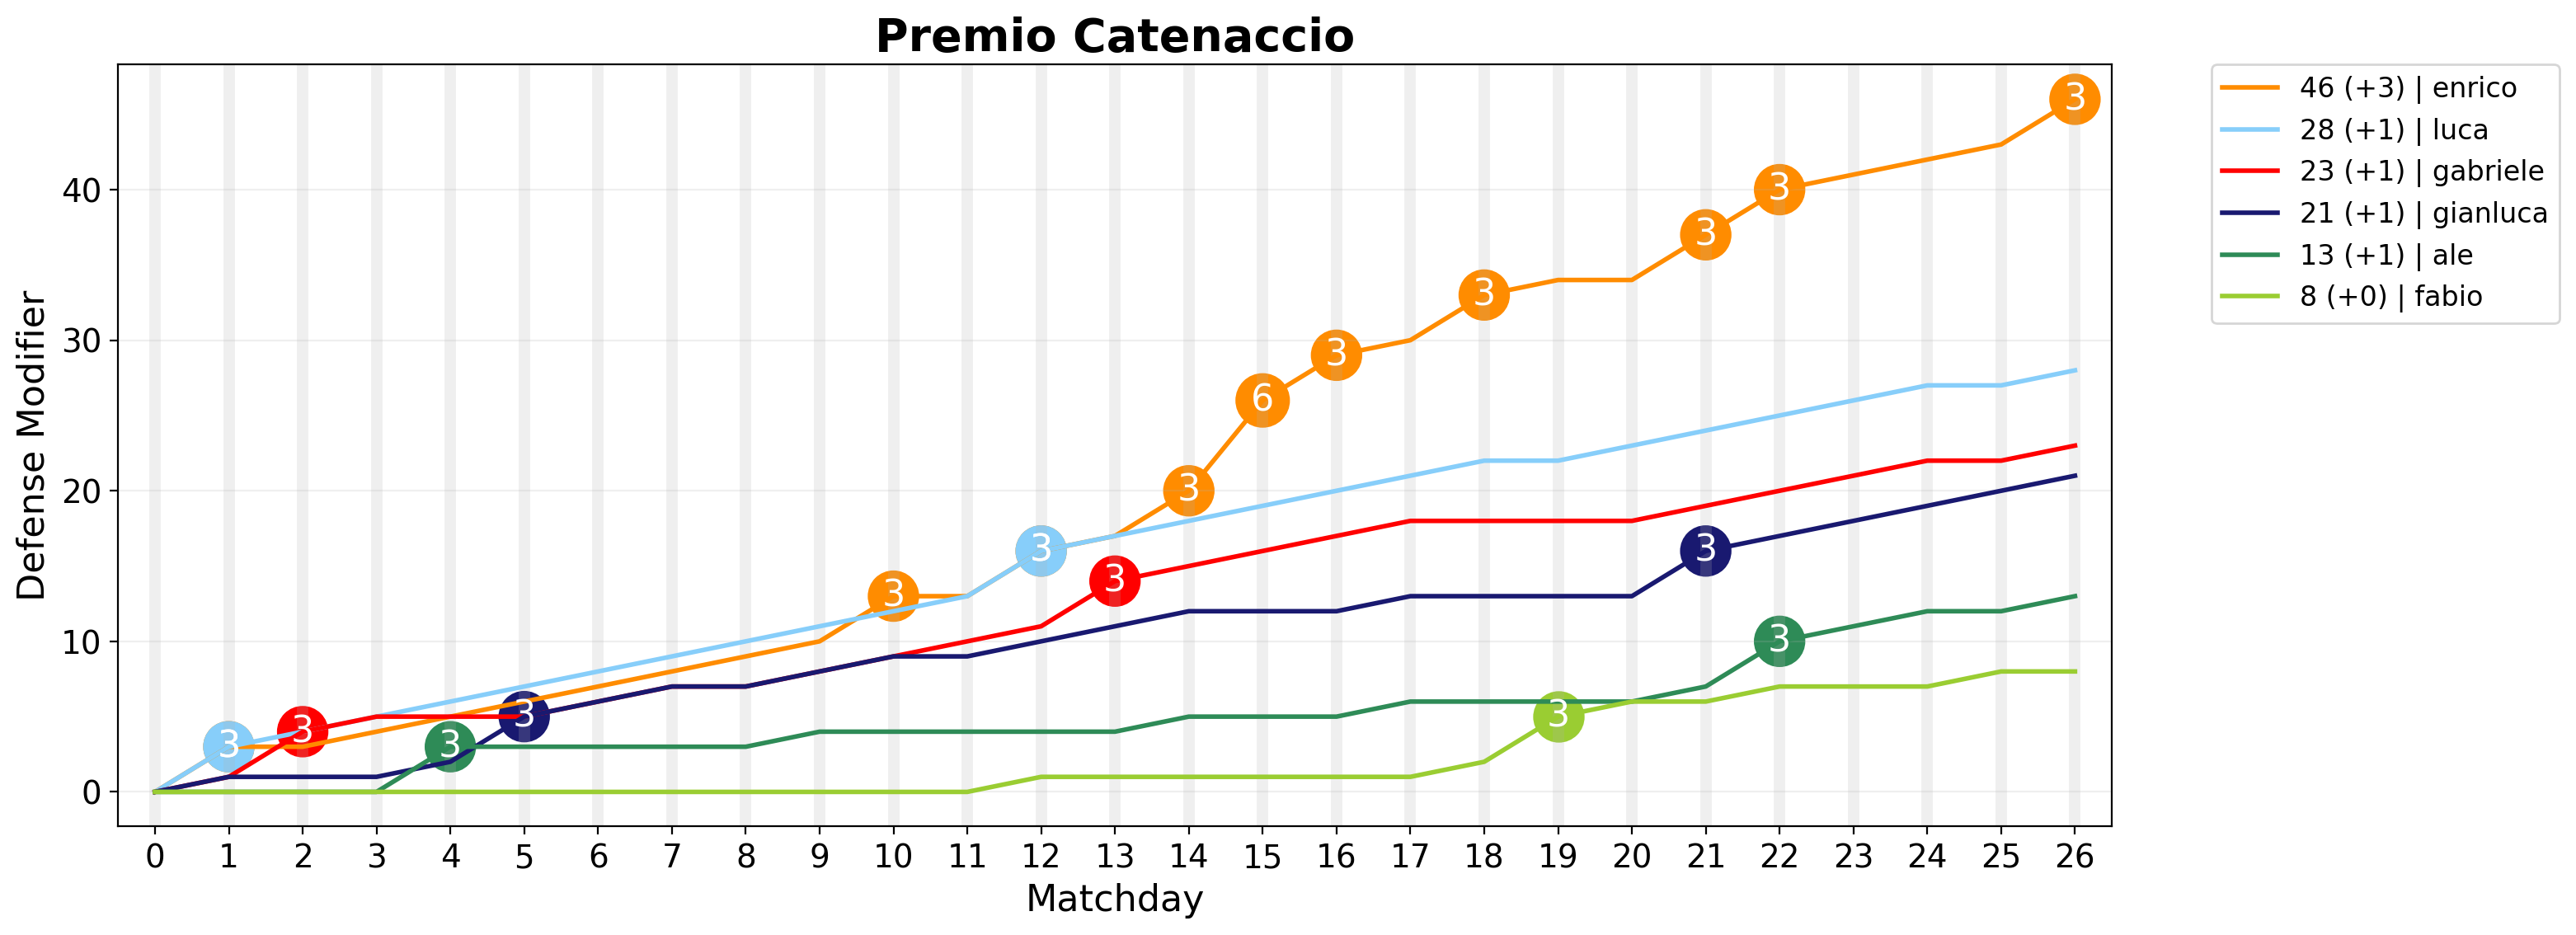

In [11]:
fanta.evo_plot(games, df_final, par='points', title='Classification Evolution', ylabel='Points', threshold=4)
fanta.evo_plot(games, df_final, par='Luck Index', title='Luck Index Evolution', ylabel='Luck Index', threshold=1.9)
fanta.evo_plot(games, df_final,
               par='goals against gk', title='Premio Porta Violata', ylabel='Goals Against Goalkeeper', threshold=2)
fanta.evo_plot(games, df_final,
               par='cards', title='Premio Cartellino Facile', ylabel='Cards', threshold=3)
fanta.evo_plot(games, df_final,
               par='defense modifier', title='Premio Catenaccio', ylabel='Defense Modifier', threshold=2) 

# Box plots

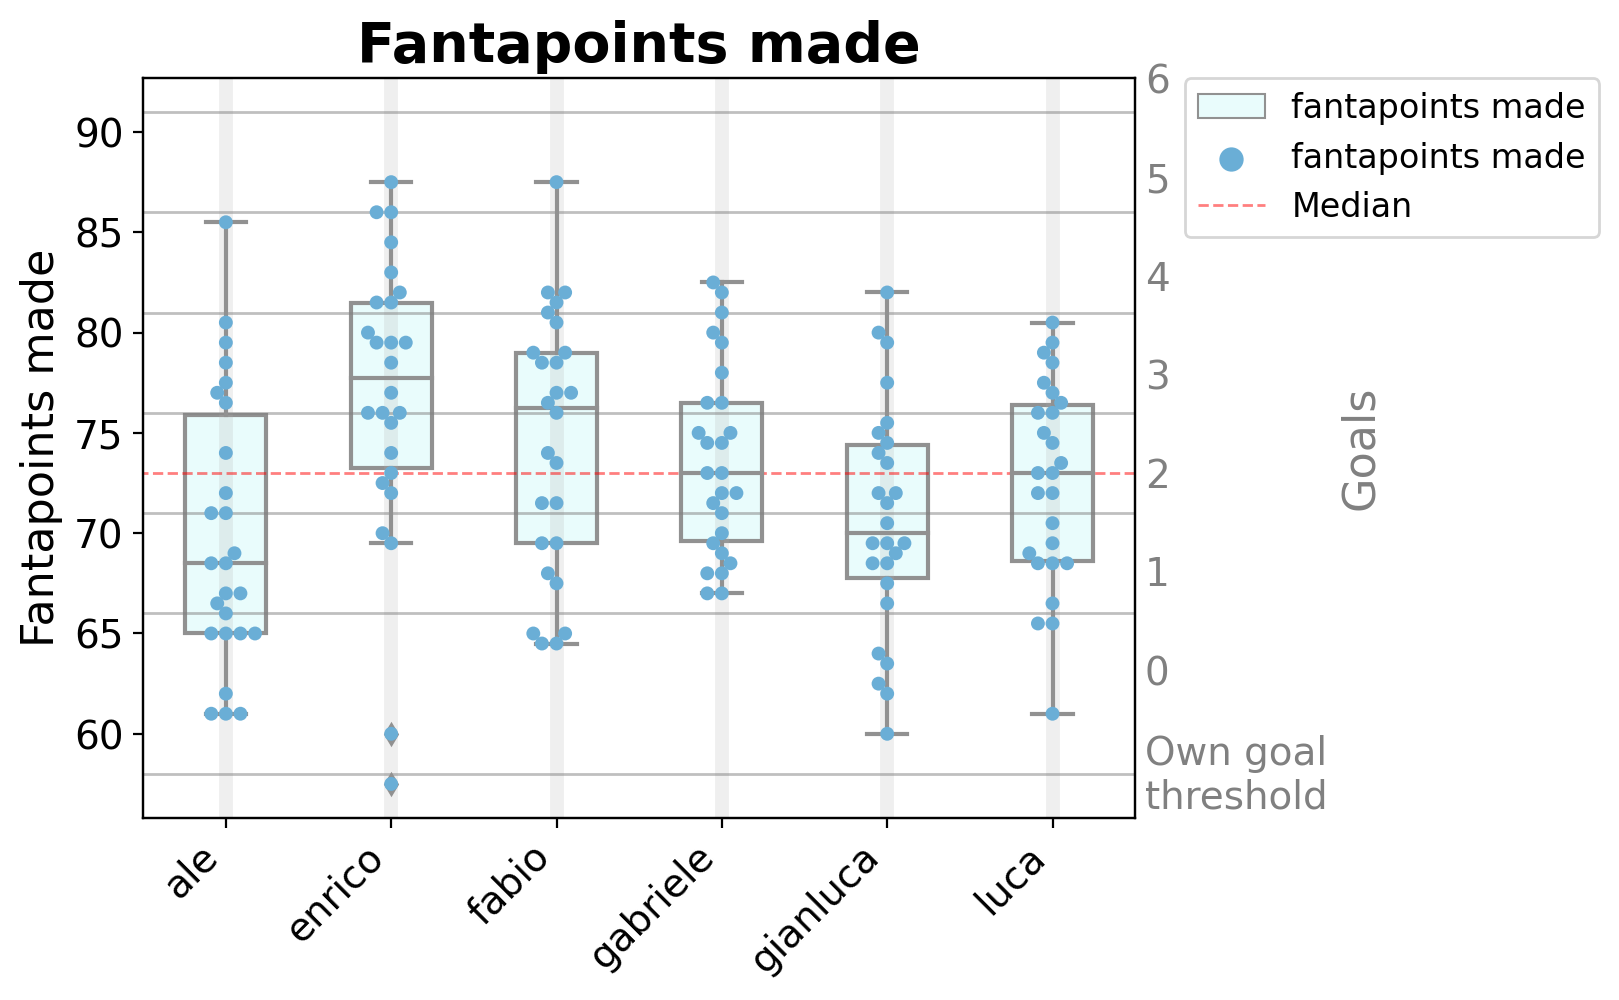

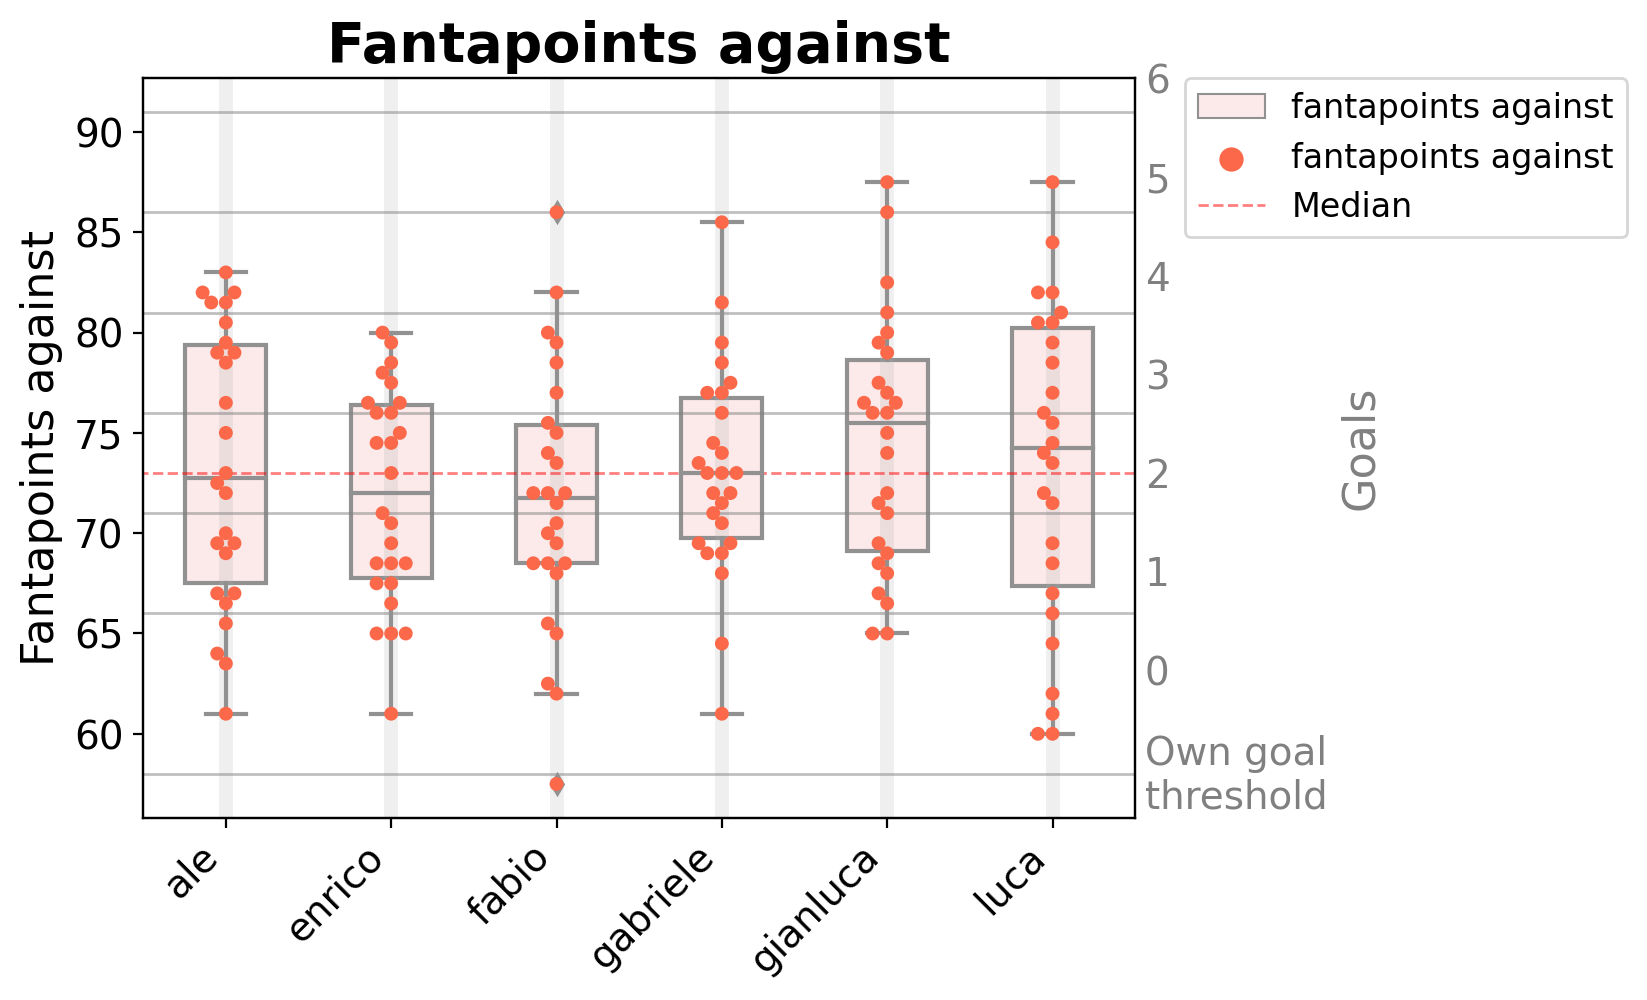

In [12]:
fanta.box_plot(df_final, fp_med,
               par='fantapoints made', label= 'Fantapoints made', title='Fantapoints made', col='cyan', pal='Blues')
fanta.box_plot(df_final, fp_med,
               par='fantapoints against', label= 'Fantapoints against', title='Fantapoints against', col='r', pal='Reds')

# Grahical display of results

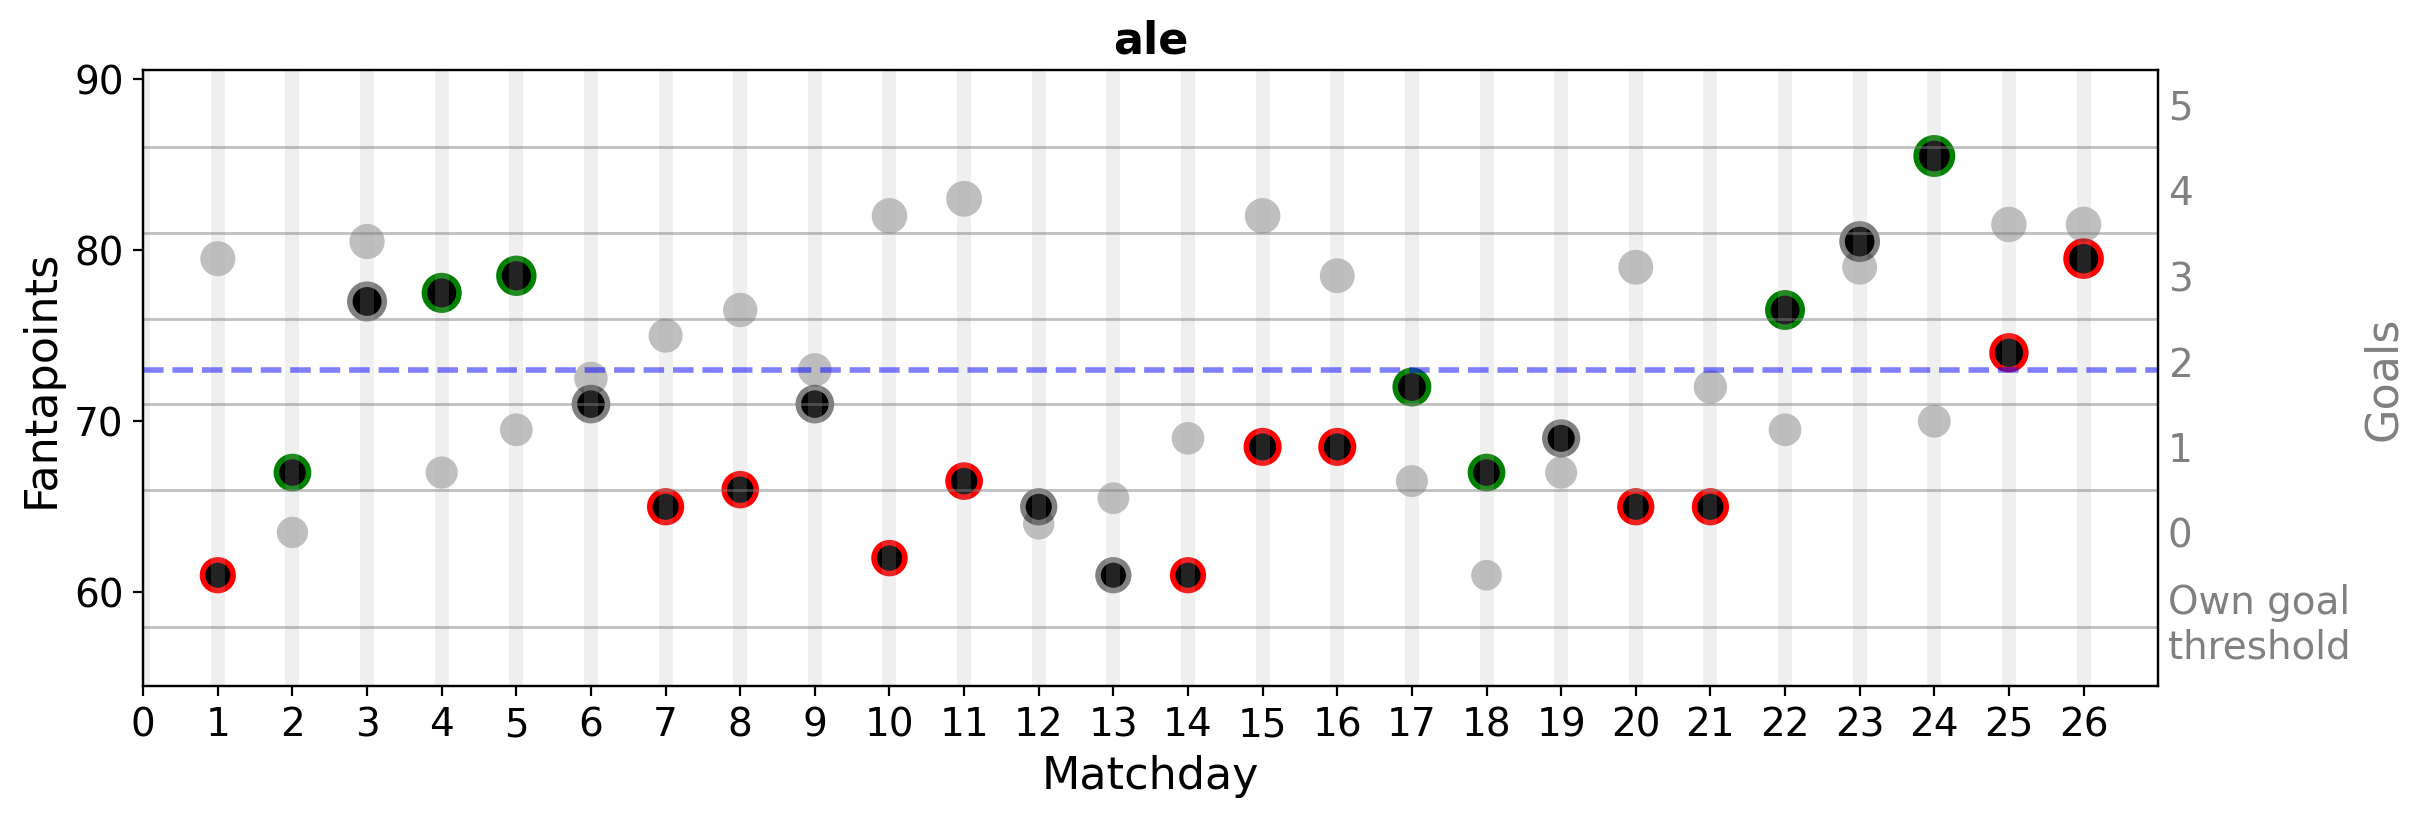

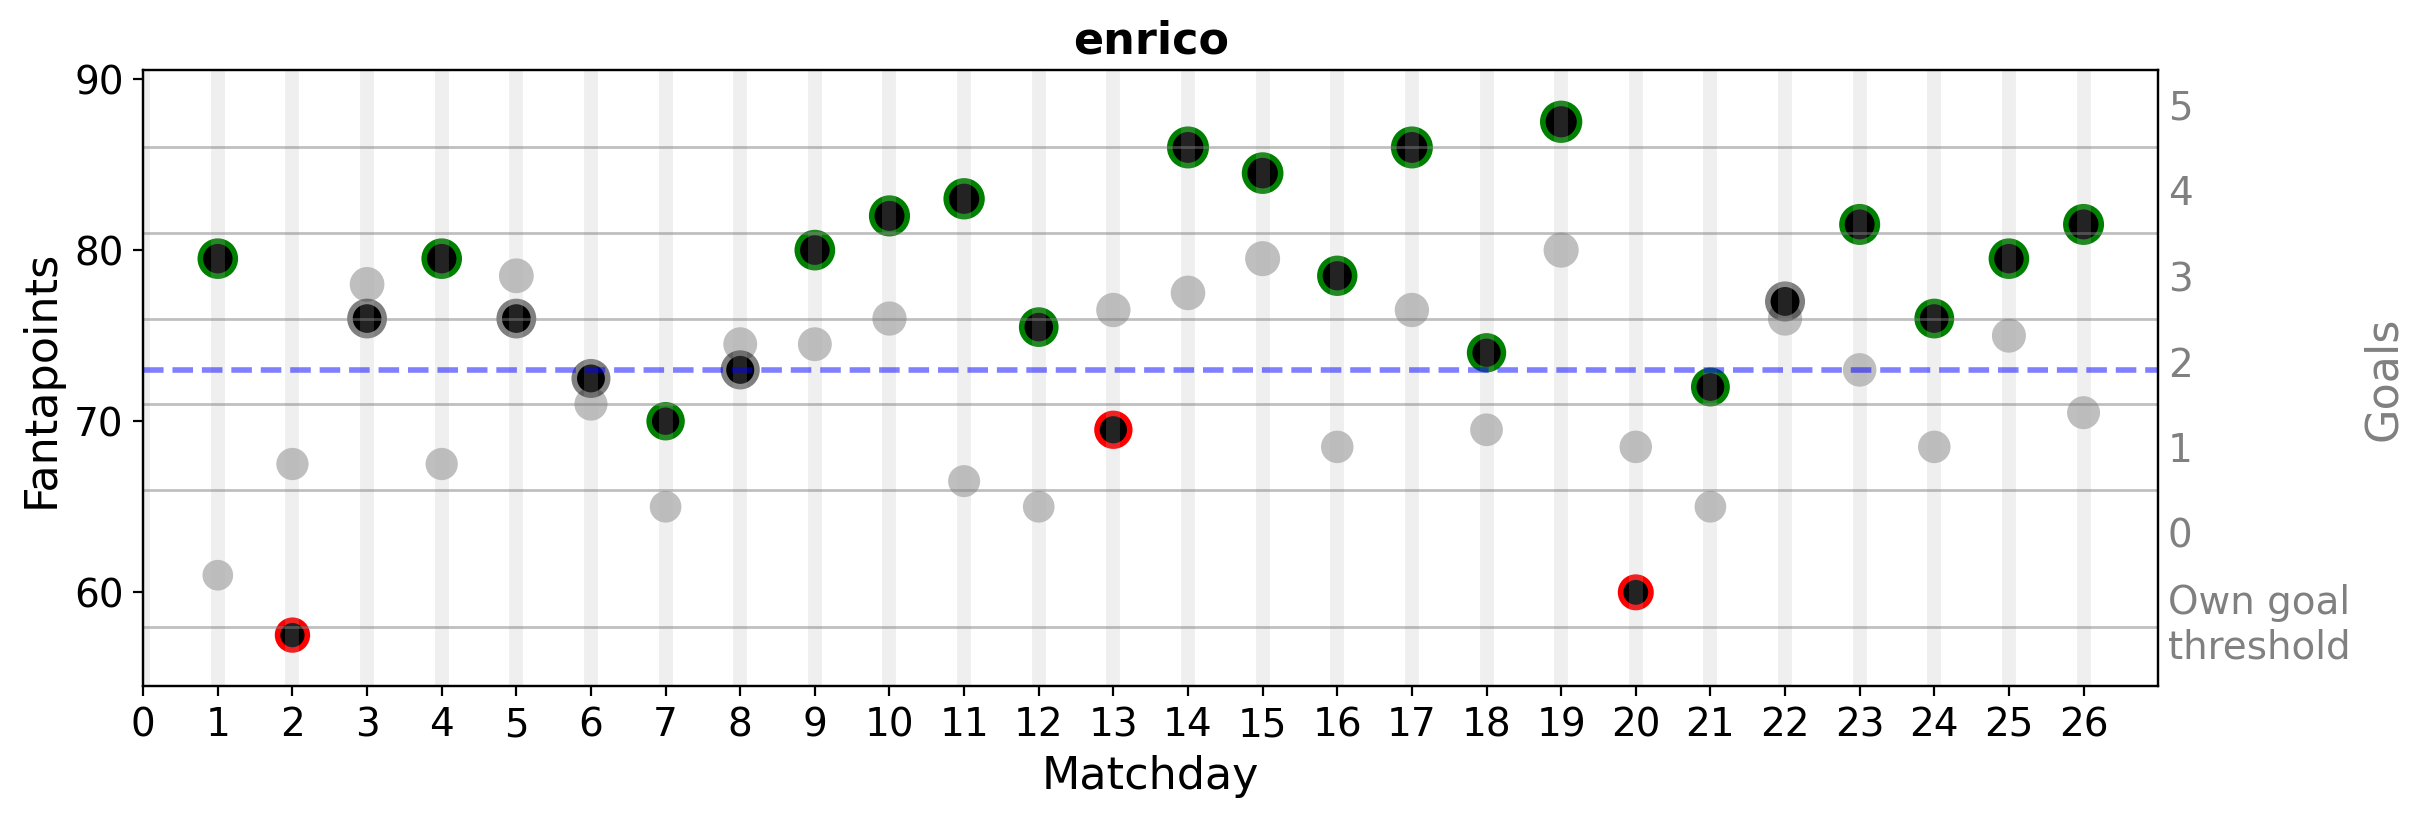

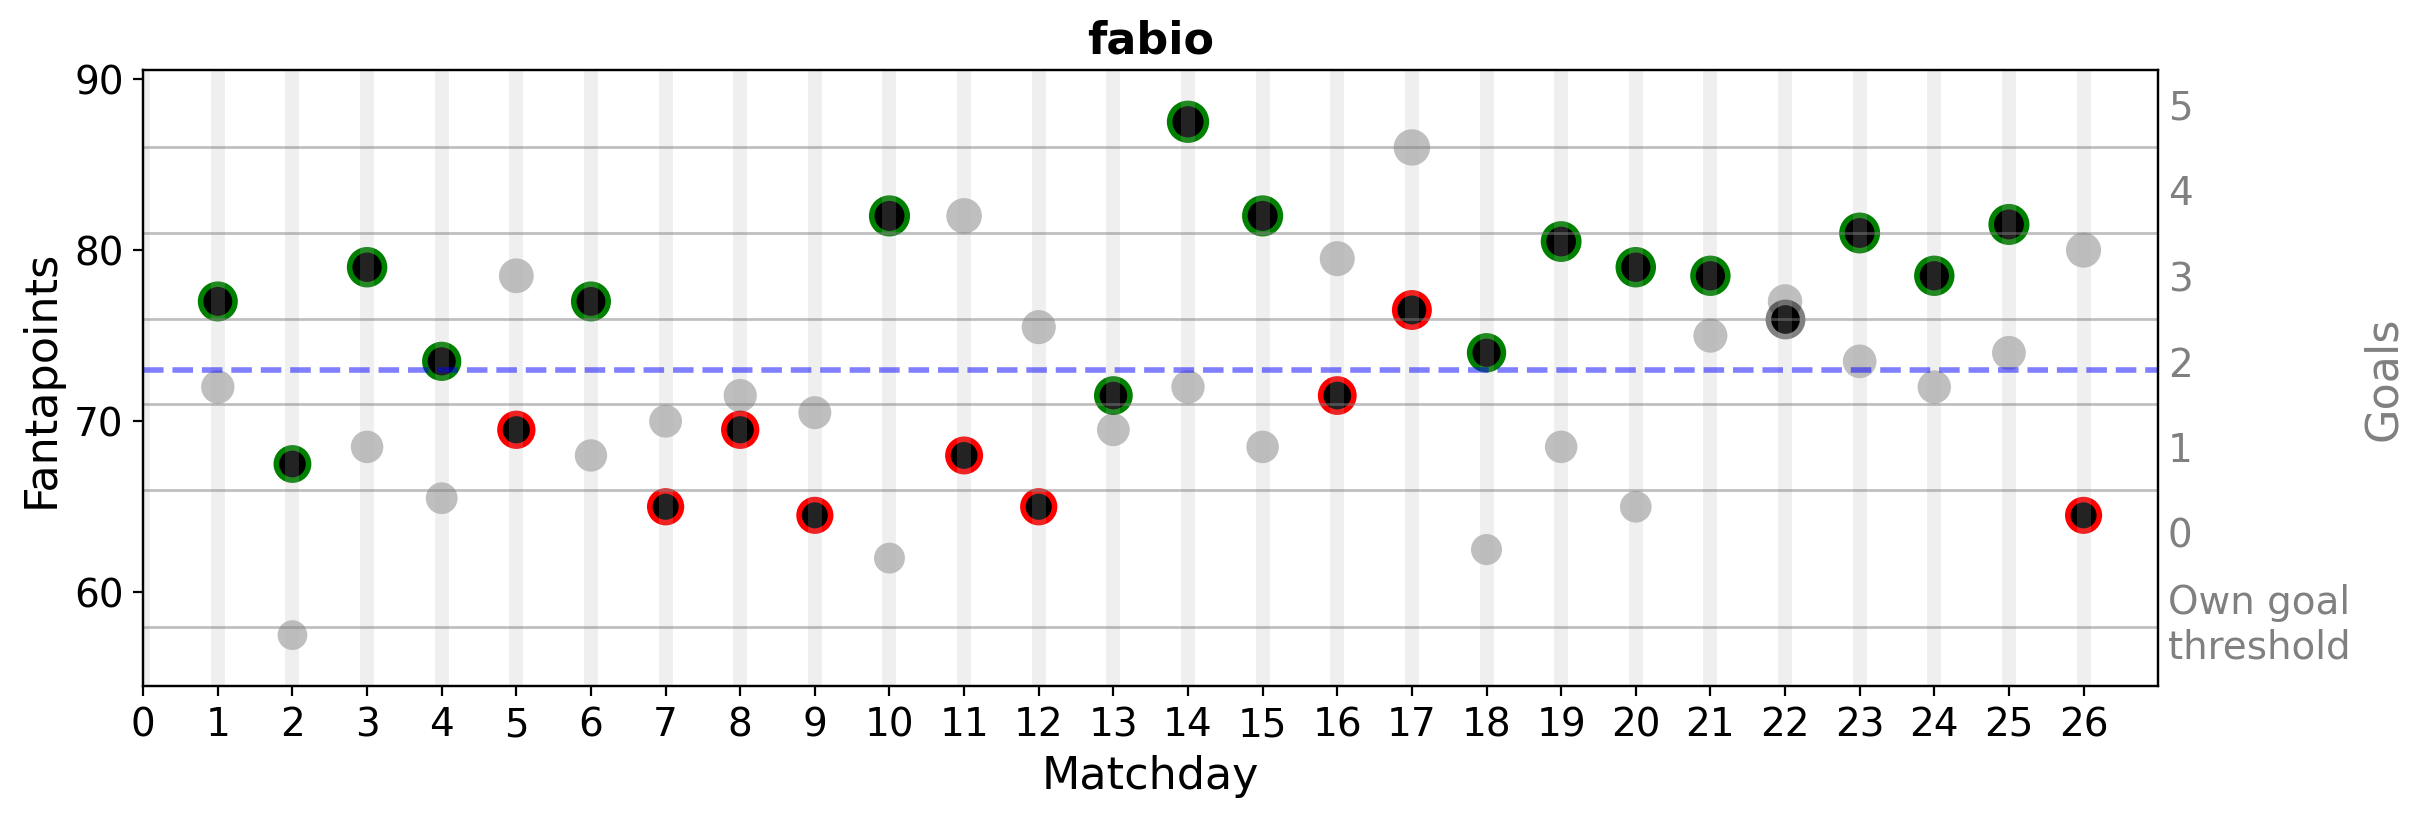

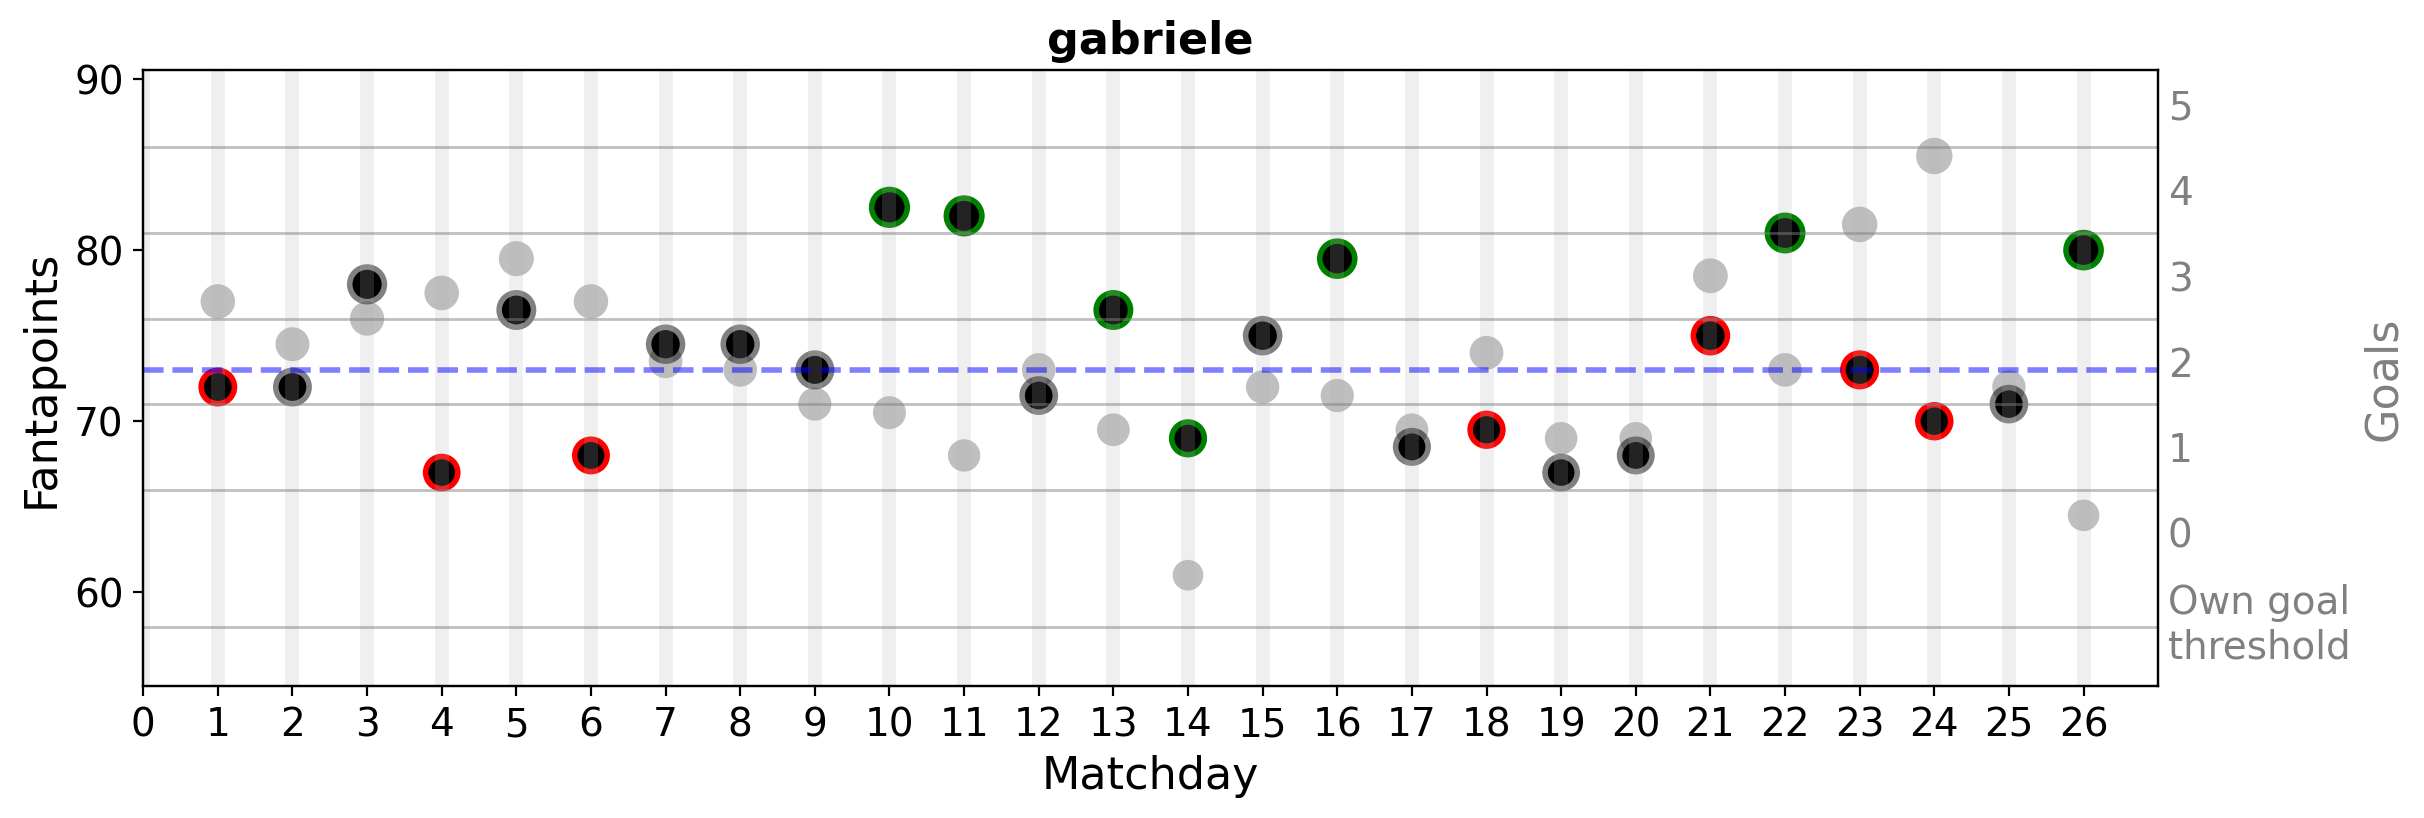

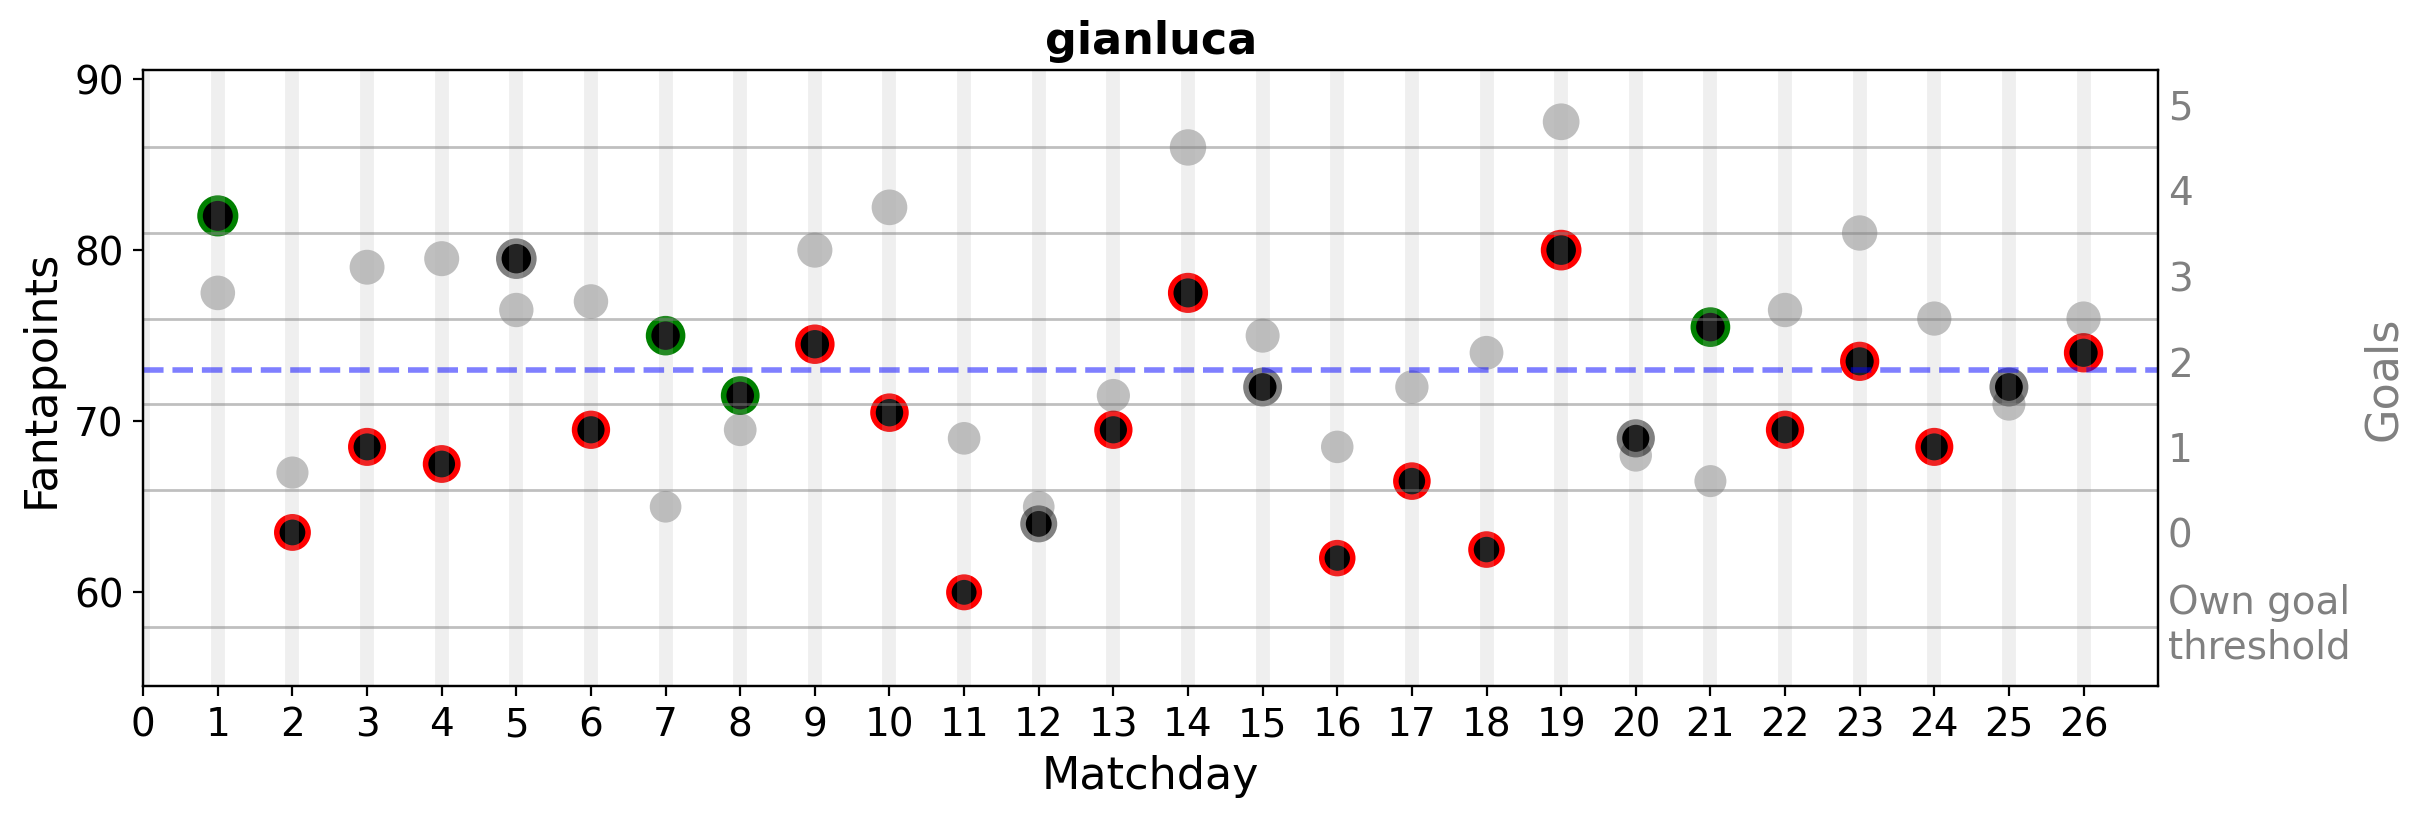

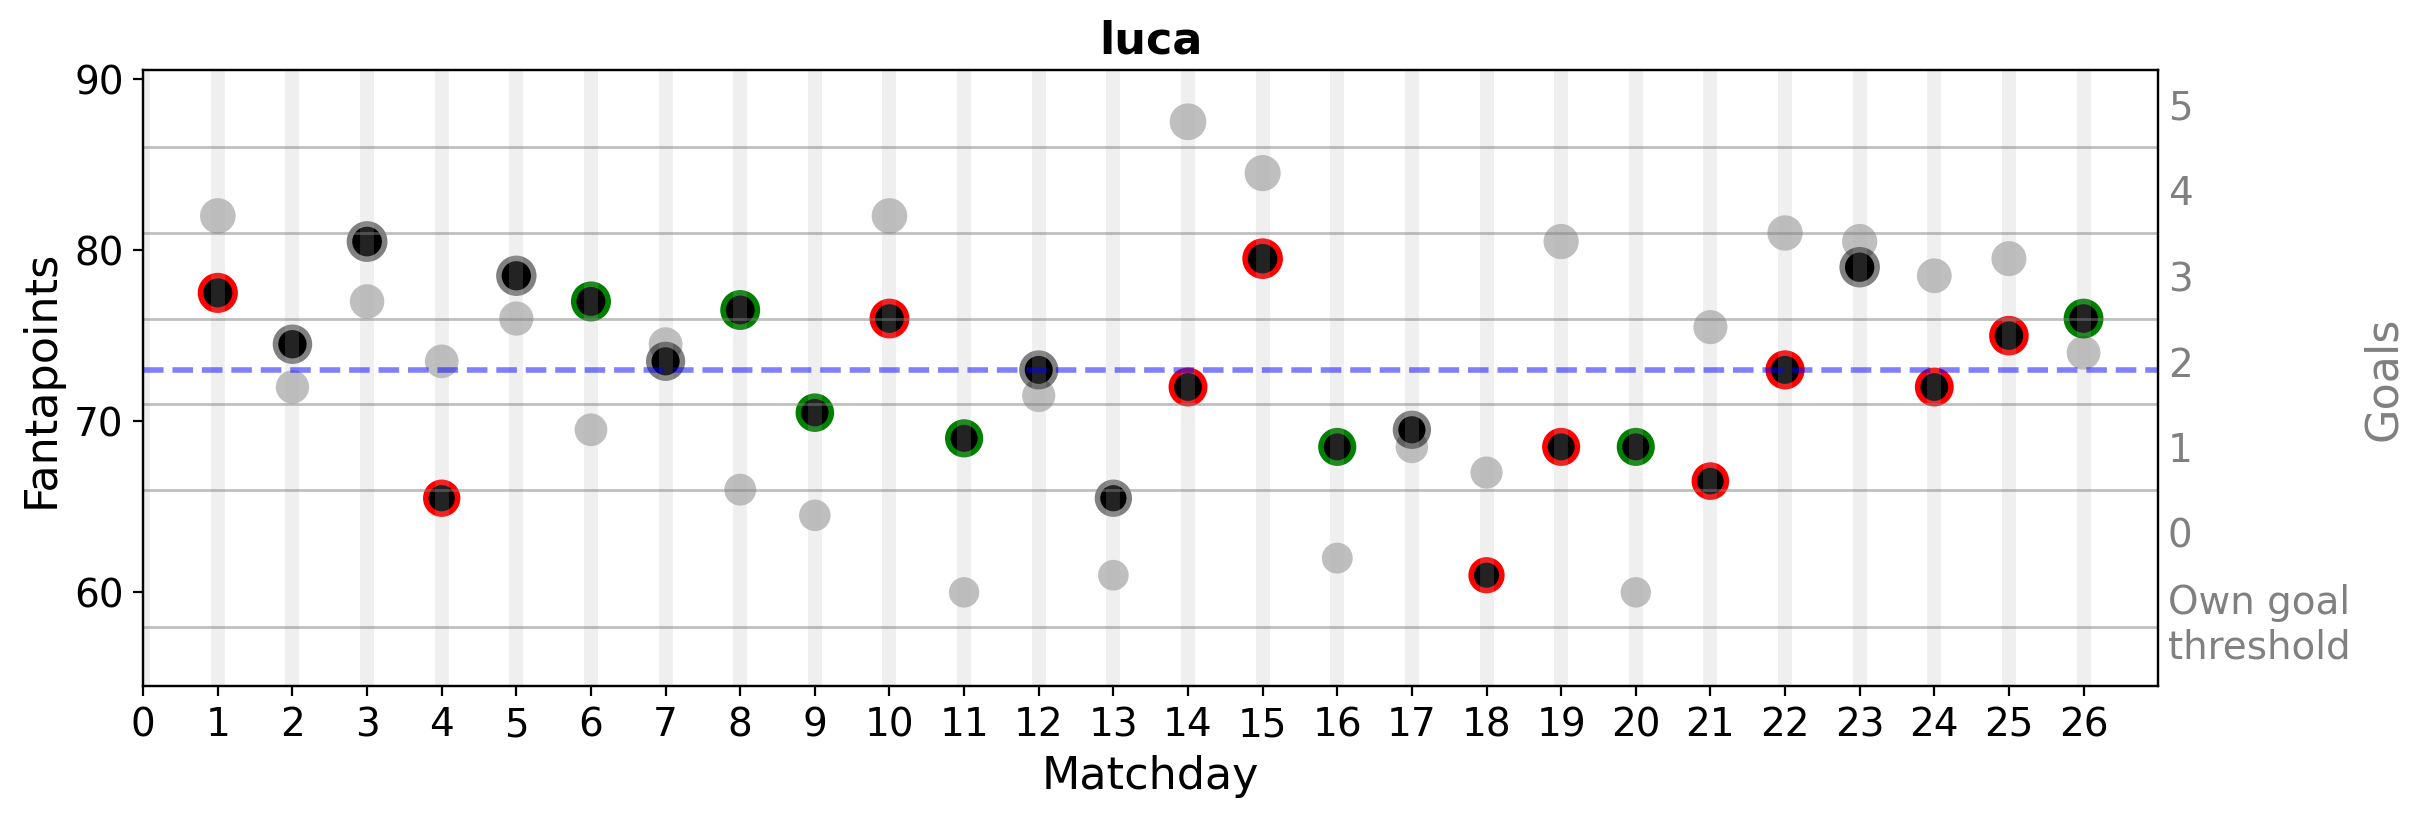

In [13]:
fanta.graphical_results(df_final, games, fp_med)

# Points and Goals vs Expected values

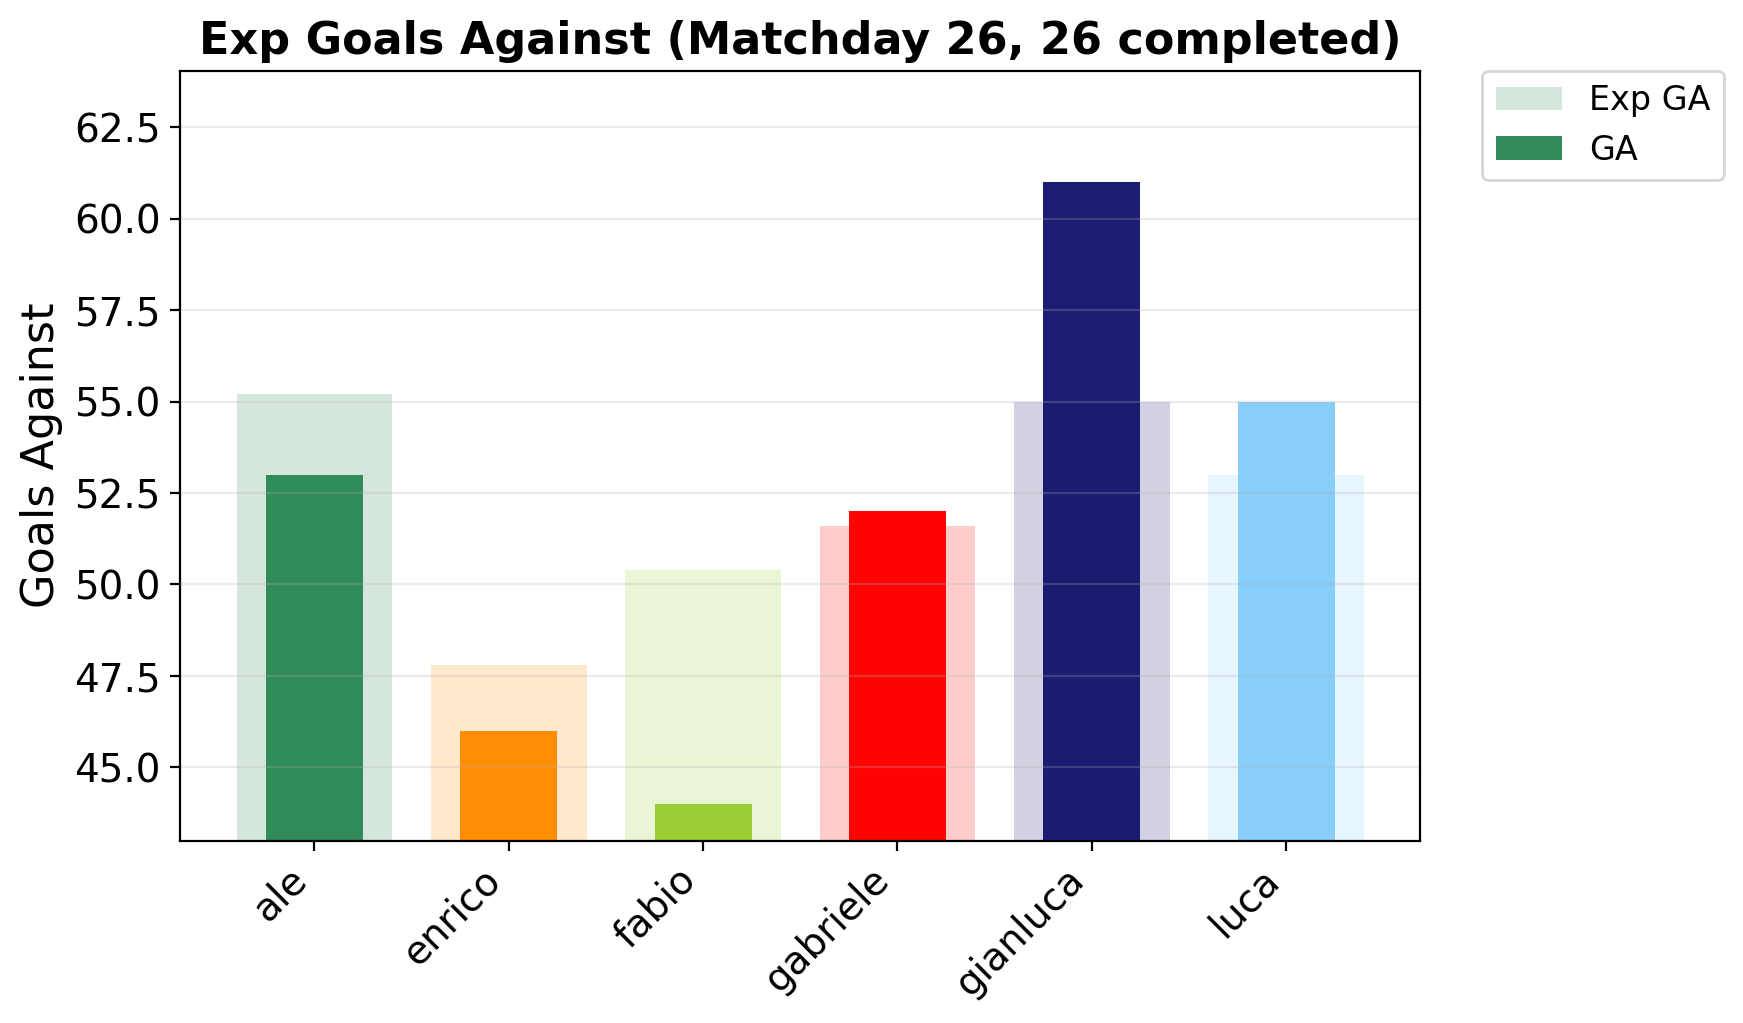

In [14]:
### Expected value of goals against, facing all other opponents ##############################
fanta.exp_goal_plot(df_total, games, games_completed)

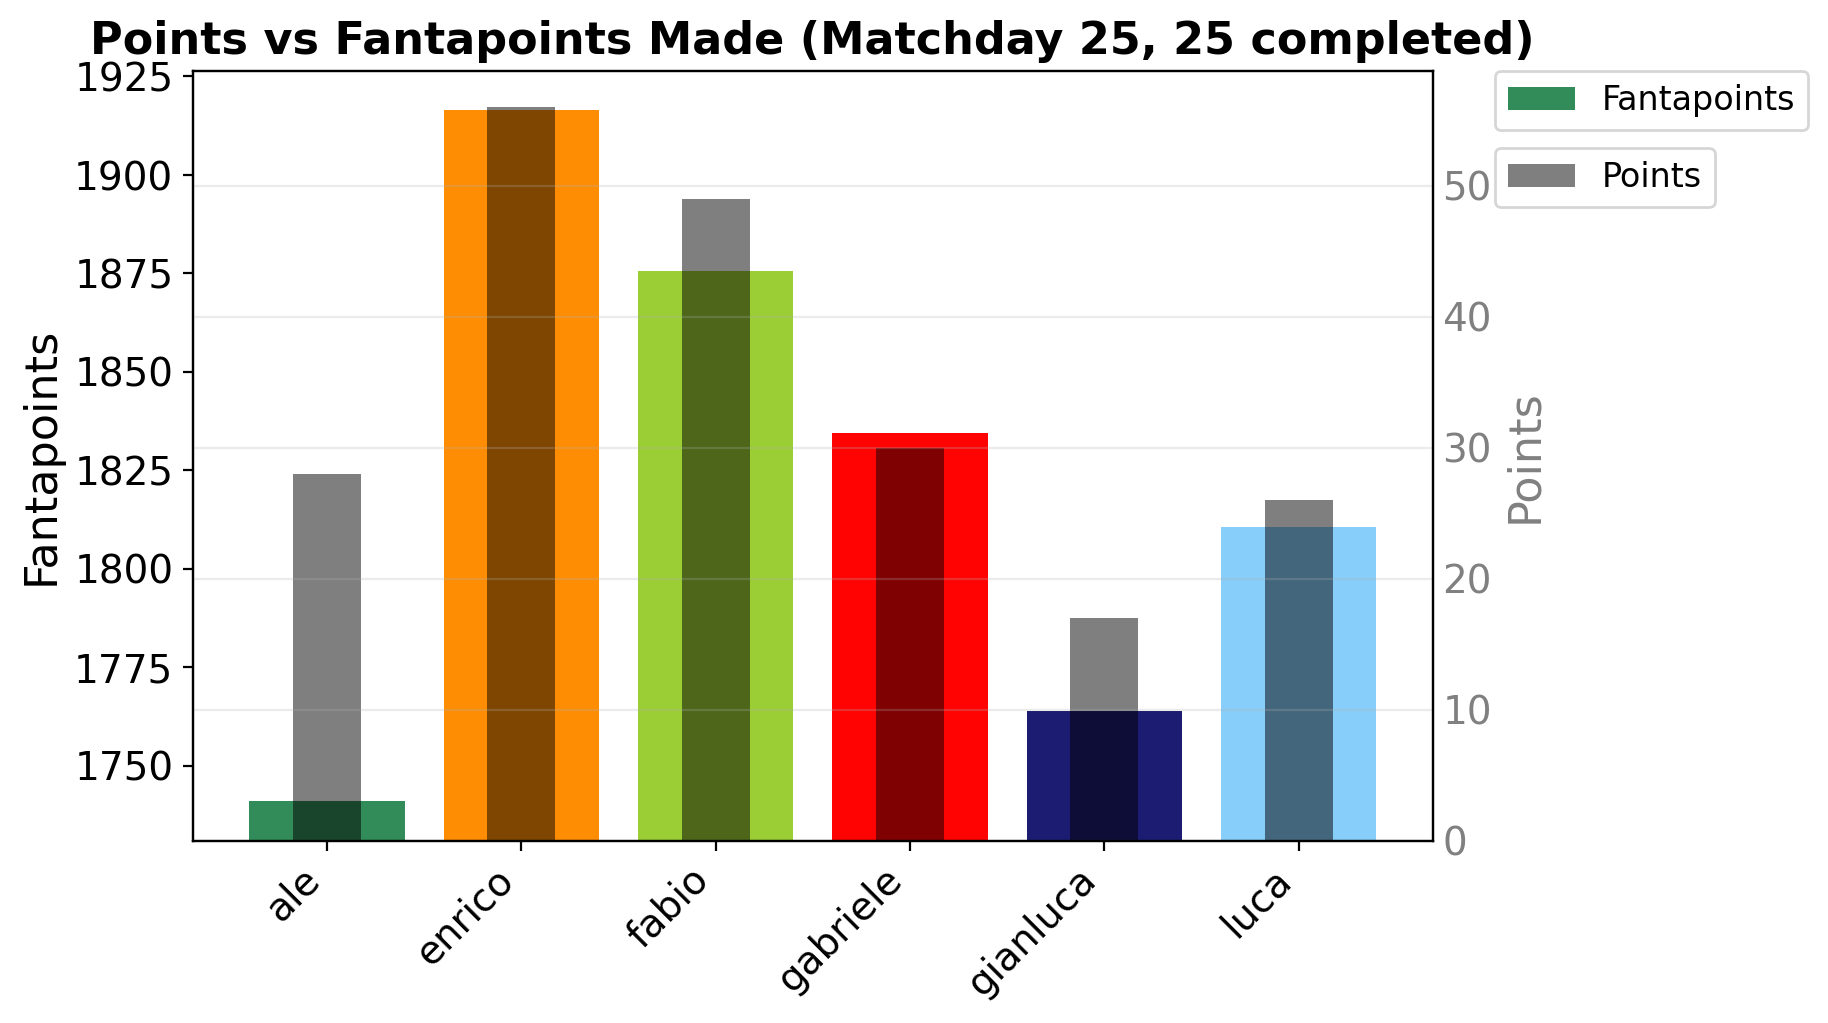

In [15]:
### Fantapoints made vs classification ###############
fanta.fantap_vs_class(df_total, games, games_completed)

# Stats & more

In [16]:
print('### CUMULATIVE DATA after matchday', games, '(', games_completed,' completed )  ###')
print('Fantapoints made:\n average =', fp_mean, '\n median =', fp_med, '\n standard deviation =', fp_std, 
      '\nGoals made:\n average =', gm_mean, '\n median =', gm_med, '\n standard deviation =', gm_std
     )

### Personal stats #####################################
personal_average = {}
for team, new_df in df_final.groupby(['team']):
    personal_average[team] = np.mean(new_df['fantapoints made'])
print('\n Personal Averages (Fantapoints):')
display(personal_average)

### CUMULATIVE DATA after matchday 25 ( 25  completed )  ###
Fantapoints made:
 average = 72.94666666666667 
 median = 73.0 
 standard deviation = 6.373158993431401 
Goals made:
 average = 1.9866666666666666 
 median = 2.0 
 standard deviation = 1.2805554350445827

 Personal Averages (Fantapoints):


{'ale': 69.64,
 'enrico': 76.66,
 'fabio': 75.02,
 'gabriele': 73.38,
 'gianluca': 70.56,
 'luca': 72.42}

In [17]:
### Display data divided by player

print('### PERSONAL DATA ###\n')

gms = np.arange(1, games+1)

for team, new_df in df_final.groupby(['team']):
    print('Team:', config.Teams[team][0], '(',team,')')
    display(new_df.drop(['team'], axis=1).reindex(gms, fill_value='--'))
    print('\n\n')

### PERSONAL DATA ###

Team: Sanfa ( ale )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,61.0,79.5,2,1,0,0,3,L,0,0.0,0.0,0.0
2,67.0,63.5,1,0,0,1,0,W,3,0.6,1.8,2.4
3,77.0,80.5,3,4,0,3,3,T,1,0.7,-0.4,0.3
4,77.5,67.0,1,2,3,3,1,W,3,0.0,0.4,0.4
5,78.5,69.5,1,0,0,3,1,W,3,0.0,1.6,1.6
6,71.0,72.5,1,1,0,2,2,T,1,0.3,-0.4,-0.1
7,65.0,75.0,4,5,0,0,2,L,0,0.0,-0.2,-0.2
8,66.0,76.5,2,1,0,1,3,L,0,0.0,-0.2,-0.2
9,71.0,73.0,0,2,1,2,2,T,1,0.4,-0.6,-0.2





Team: Gianlucanonpressare ( enrico )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,79.5,61.0,1,2,3,3,0,W,3,0.0,1.4,1.4
2,57.5,67.5,2,4,0,0,2,L,0,0.0,-0.2,-0.2
3,76.0,78.0,0,3,1,3,3,T,1,0.4,-0.4,0.0
4,79.5,67.5,1,1,1,3,1,W,3,0.0,0.4,0.4
5,76.0,78.5,1,2,1,3,3,T,1,0.5,-0.4,0.1
6,72.5,71.0,0,2,1,2,2,T,1,-0.6,-0.4,-1.0
7,70.0,65.0,1,3,1,1,0,W,3,0.0,1.8,1.8
8,73.0,74.5,2,4,1,2,2,T,1,0.3,-0.6,-0.3
9,80.0,74.5,0,2,1,3,2,W,3,0.0,0.0,0.0





Team: Porti Chiusi Italiani ( fabio )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,77.0,72.0,3,3,0,3,2,W,3,0.0,1.4,1.4
2,67.5,57.5,1,2,0,2,0,W,3,0.0,0.8,0.8
3,79.0,68.5,4,2,0,3,1,W,3,0.0,1.6,1.6
4,73.5,65.5,0,1,0,2,0,W,3,0.0,1.2,1.2
5,69.5,78.5,2,2,0,1,3,L,0,0.0,0.0,0.0
6,77.0,68.0,1,3,0,3,1,W,3,0.0,0.4,0.4
7,65.0,70.0,1,3,0,0,1,L,0,0.0,-0.2,-0.2
8,69.5,71.5,0,0,0,1,2,L,0,-0.6,-0.2,-0.8
9,64.5,70.5,0,1,0,0,1,L,0,0.0,0.0,0.0





Team: Sciagura ( gabriele )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,72.0,77.0,0,1,1,2,3,L,0,0.0,-0.6,-0.6
2,72.0,74.5,0,3,3,2,2,T,1,0.5,-1.2,-0.7
3,78.0,76.0,1,2,1,3,3,T,1,-0.8,-0.4,-1.2
4,67.0,77.5,2,2,0,1,3,L,0,0.0,-0.8,-0.8
5,76.5,79.5,3,2,0,3,3,T,1,0.6,-0.4,0.2
6,68.0,77.0,2,3,1,1,3,L,0,0.0,-0.2,-0.2
7,74.5,73.5,1,6,1,2,2,T,1,-0.4,-1.2,-1.6
8,74.5,73.0,1,3,0,2,2,T,1,-0.6,-0.6,-1.2
9,73.0,71.0,1,3,1,2,2,T,1,-0.8,-0.6,-1.4





Team: La mamma di Enrico ( gianluca )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,82.0,77.5,1,1,1,4,3,W,3,0.2,0.0,0.2
2,63.5,67.0,1,3,0,0,1,L,0,-0.3,-0.2,-0.5
3,68.5,79.0,1,1,0,1,3,L,0,0.0,0.0,0.0
4,67.5,79.5,0,3,1,1,3,L,0,0.0,-0.8,-0.8
5,79.5,76.5,0,2,3,3,3,T,1,-1.2,-0.4,-1.6
6,69.5,77.0,1,1,1,1,3,L,0,0.0,-0.2,-0.2
7,75.0,65.0,0,1,1,2,0,W,3,0.0,0.8,0.8
8,71.5,69.5,1,1,0,2,1,W,3,1.2,1.4,2.6
9,74.5,80.0,0,2,1,2,3,L,0,0.0,-1.6,-1.6





Team: Nottingham Forrest Gump ( luca )


,fantapoints made,fantapoints against,goals against gk,cards,defense modifier,GM,GA,result,points,f_close_games,f_day_average,Luck Index
Game,,,,,,,,,,,,
1,77.5,82.0,0,1,3,3,4,L,0,-0.1,-1.6,-1.7
2,74.5,72.0,2,1,1,2,2,T,1,-1.0,-1.2,-2.2
3,80.5,77.0,0,0,1,3,3,T,1,-1.4,-0.4,-1.8
4,65.5,73.5,2,1,1,0,2,L,0,0.0,0.0,0.0
5,78.5,76.0,0,3,1,3,3,T,1,-1.0,-0.4,-1.4
6,77.0,69.5,1,1,1,3,1,W,3,0.0,0.4,0.4
7,73.5,74.5,0,0,1,2,2,T,1,0.2,-1.2,-1.0
8,76.5,66.0,1,2,1,3,1,W,3,0.0,0.0,0.0
9,70.5,64.5,2,3,1,1,0,W,3,0.0,2.4,2.4
